# Michał Stawikowski Lab5


In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import math
import itertools
import sys
np.set_printoptions(threshold=sys.maxsize)
import timeit
from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib
import scipy
from scipy import special
from scipy.stats import norm
%matplotlib inline

plt.rcParams["figure.figsize"] = (12, 8)
plt.style.use("bmh")
font = {
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# 1.

## Implementation

In [86]:
#Market instance
class CRR_Market(object):
    
    def __init__(self, T, S, r, sigma, N):
        self.T = T #Number of periods
        self.S = S #S_0 = const
        self.r = r #Interest rate
        self.N = N
        self.sigma = sigma
        self.u = math.exp(sigma*math.sqrt(T/N))
        self.d = math.exp(-sigma*math.sqrt(T/N))
        a = math.exp(r*T/N) - math.exp(-sigma*math.sqrt(T/N))
        b = math.exp(sigma*math.sqrt(T/N)) - math.exp(-sigma*math.sqrt(T/N))
        self.p = a/b #Risk neutral probability
        self.discount = math.exp(-r*T/N)
        self.is_calculated = 0
    

    def priceOption(self, option, verbose = False): #Method for pricing options, 
#better optimized for options than pricePayout (especially for European options)
        option_values = np.zeros(self.N+1) 
        ST = [self.S * self.d ** (self.N-i) * self.u ** (i) for i in range(0,self.N + 1)]
        # stock values at T
        
        if (option.eu_am == "European"):
            
            for j in range(1, self.N+1): #Option values at T, simplified version without
                #identical payouts
                if option.put_call == 'Put':
                    option_values[j] = max(option.K-ST[j],0)
                elif option.put_call == 'Call':
                    option_values[j] = max(ST[j]-option.K,0)
            
            if(verbose): #Printing informations
                print("Option Values at T:")
                print(option_values)
            
            for i in range(self.N, 0, -1):  #Rest of layers of option values (at T-1,...,0)
                for j in range(0, i):
                    #Expected values calcucation
                    option_values[j] = self.discount*(self.p*option_values[j+1]+(1-self.p)*option_values[j])
            
            return option_values[0] #Option value at 0
        
        if (option.eu_am == "American"):
            if (not self.is_calculated):
                St = np.zeros((self.N+1,self.N+1)) #Stock values tree calcucation
                St[0,0] = self.S
                for i in range(1,self.N+1):
                    St[i,0] = St[i-1,0]*self.u
                    for j in range(1,i+1):
                        St[i,j] = St[i-1,j-1]*self.d
                self.St = St #Values of recombination tree
                self.is_calculated = 1
            
            option_values = np.zeros((self.N+1,self.N+1))
            
            for i in range(0,self.N+1): #Option values at T
                if option.put_call == 'Call':
                    option_values[self.N,i] = max(0, self.St[self.N,i]-option.K)
                elif option.put_call == 'Put':
                    option_values[self.N,i] = max(0, option.K-self.St[self.N,i])
            
            if(verbose):
                print("Option Values at T:")
                print(option_values[self.N,:])
            
            for i in range(self.N, 0, -1): #Rest of layers of option values (at T-1,...,0)
                for j in range(0, i):
                    expected_value = self.discount*(self.p*option_values[i,j]+(1-self.p)*option_values[i, j+1])
                    if option.put_call == 'Call':
                        call_value = max(0, self.St[i-1,j] - option.K)
                        option_values[i-1,j] = max(call_value, expected_value)
                    elif option.put_call == 'Put':
                        put_value = max(0, option.K - self.St[i-1,j])
                        option_values[i-1,j] = max(put_value, expected_value)
            return option_values[0,0] #Option value at 0



In [3]:
#Option instance
class Option(object):
    
    def __init__(self, put_call, eu_am, K):
        self.put_call = put_call #"Put" or "Call"
        self.eu_am = eu_am  #"European" or "American"
        self.K = K #Strike price of the option
       

In [3]:
#Black Scholes pice
def Black_Scholes(T, S, r, sigma, K):
    a =  S*norm.cdf((math.log(S/K) + (r+(sigma**2)/2)*T)/(sigma*math.sqrt(T)))
    b = K*math.exp(-r*T)*norm.cdf((math.log(S/K) + (r-(sigma**2)/2)*T)/(sigma*math.sqrt(T)))
    return (a - b)
    

## Without smoothing

In [9]:
 #Market parameters
T = 2
S = 100
r = 0.05
sigma = 0.3
K = 110

In [126]:
dedicated_option = Option("Call", "European", K)

Ns = np.arange(50,1000,1) #Generating prices for different ns
Price_n = []
for i in Ns:
    market = CRR_Market(T=T,S=S,r=r,sigma = sigma, N = i)
    price = market.priceOption(dedicated_option)
    Price_n.append(price)

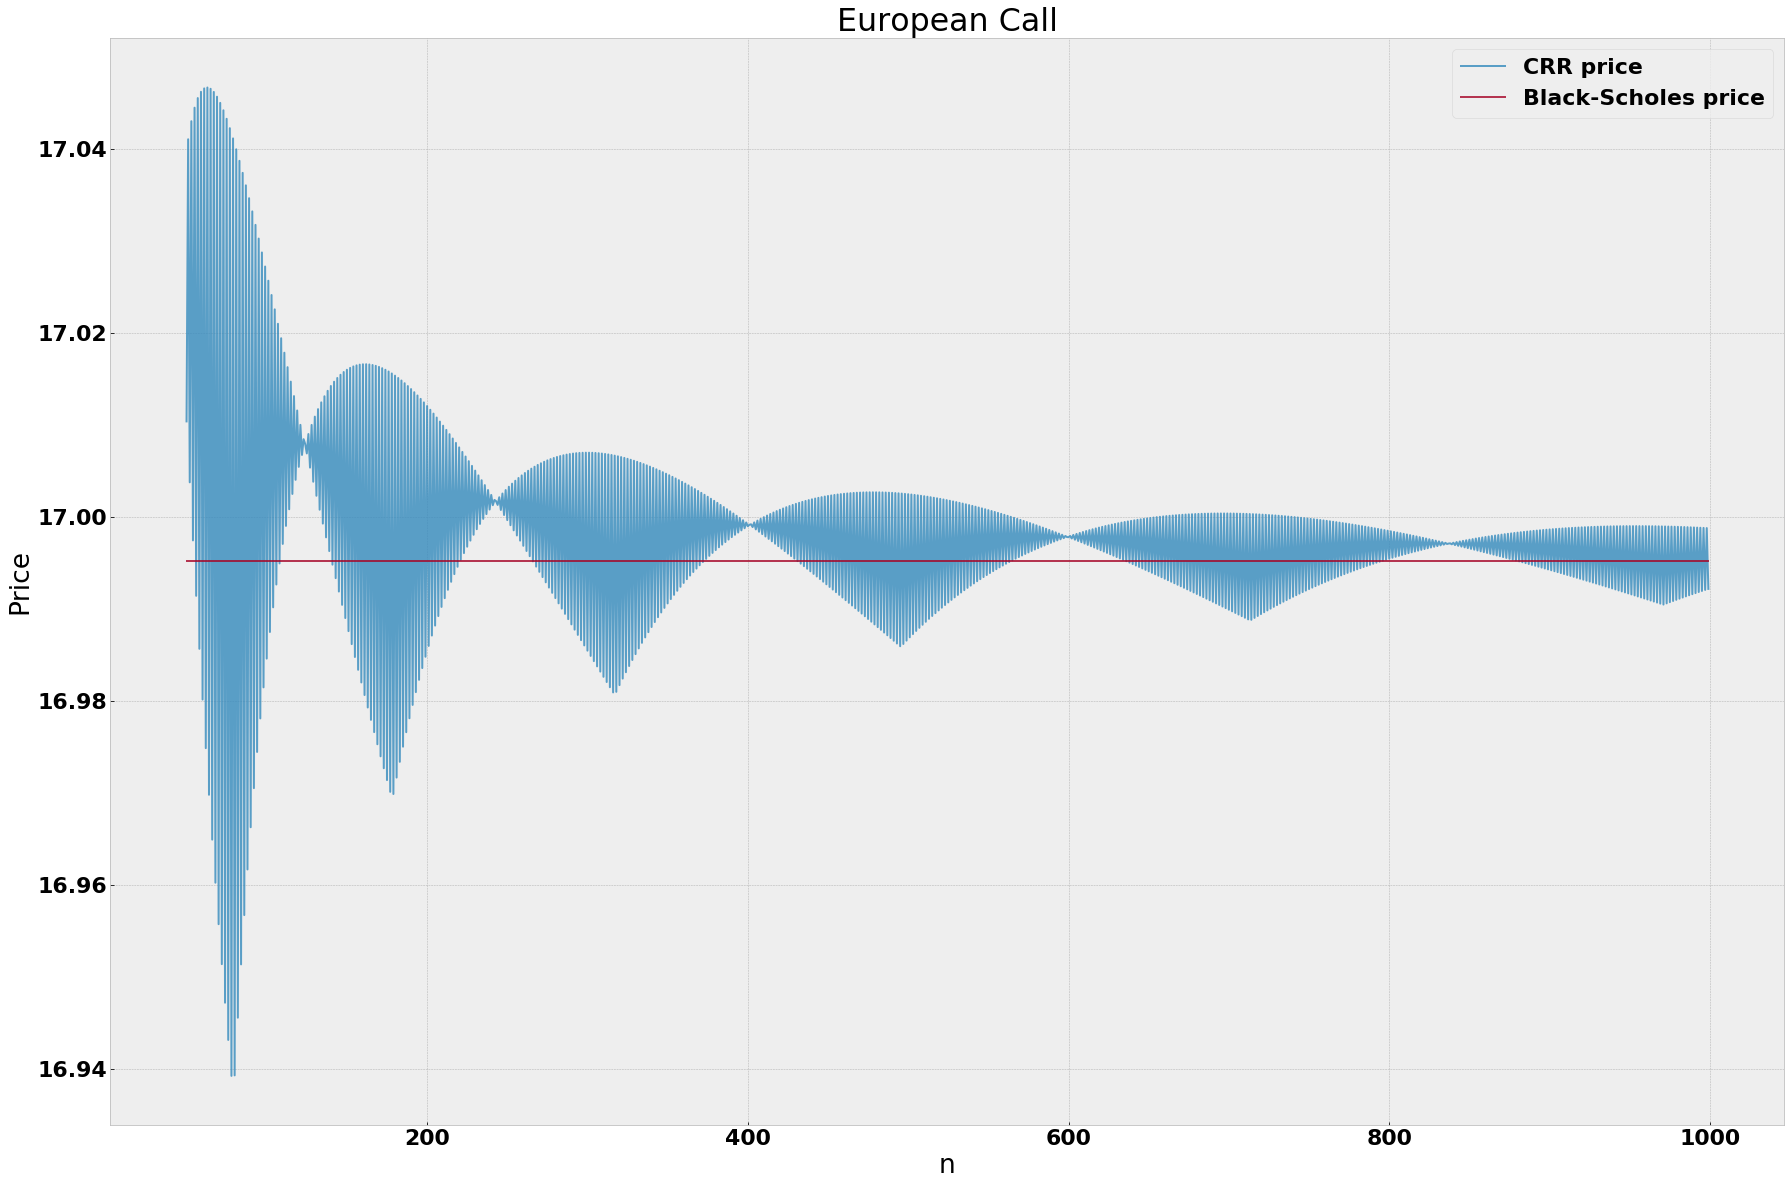

In [128]:
bs = Black_Scholes(T, S, r, sigma, K) #Black-Scholes price
a = len(Price_n)
bs = [bs]*a
fig = plt.figure(figsize = [30,20])
ax = plt.subplot(111)
plt.plot(Ns, Price_n, alpha = 0.8, markersize = 4, label = "CRR price")
plt.plot(Ns, bs, alpha = 0.8, markersize = 4, label = "Black-Scholes price")
plt.title('European Call')
plt.xlabel("n")
plt.ylabel("Price")
ax.legend()
plt.show()

## With smoothing - moving average

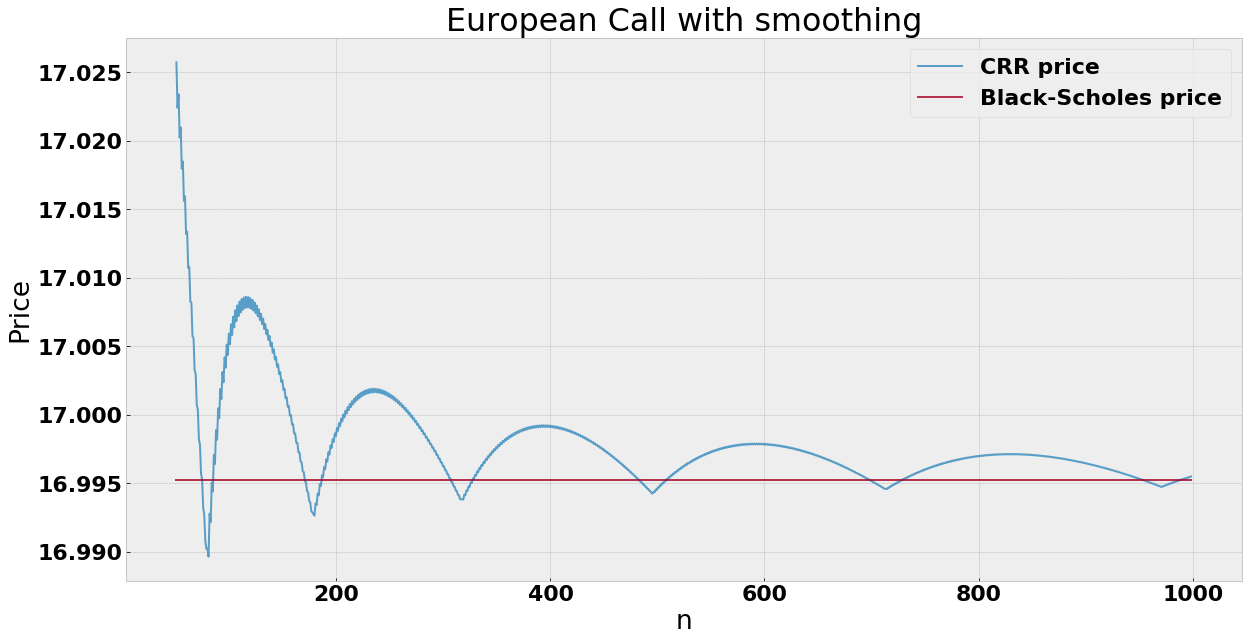

In [129]:
bs = Black_Scholes(T, S, r, sigma, K) #Black-Scholes price
moving_average = []
Ms = []
i = -1
while(i+2<len(Price_n)):
    i += 1
    moving_average.append(0.5*(Price_n[i] + Price_n[i+1]))
    Ms.append(0.5*(Ns[i] + Ns[i+1]))
a = len(Ms)
bs = [bs]*a
fig = plt.figure(figsize = [20,10])
ax = plt.subplot(111)
plt.plot(Ms, moving_average, alpha = 0.8, markersize = 4, label = "CRR price")
plt.plot(Ms, bs, alpha = 0.8, markersize = 4, label = "Black-Scholes price")
plt.title('European Call with smoothing')
plt.xlabel("n")
plt.ylabel("Price")
ax.legend()
plt.show()

## Every 50 n

In [130]:
Ns = np.arange(50,5000,50) #Generating prices for different ns
Price_n50 = []
for i in Ns:
    market = CRR_Market(T=T,S=S,r=r,sigma = sigma, N = i)
    price = market.priceOption(dedicated_option)
    Price_n50.append(price)

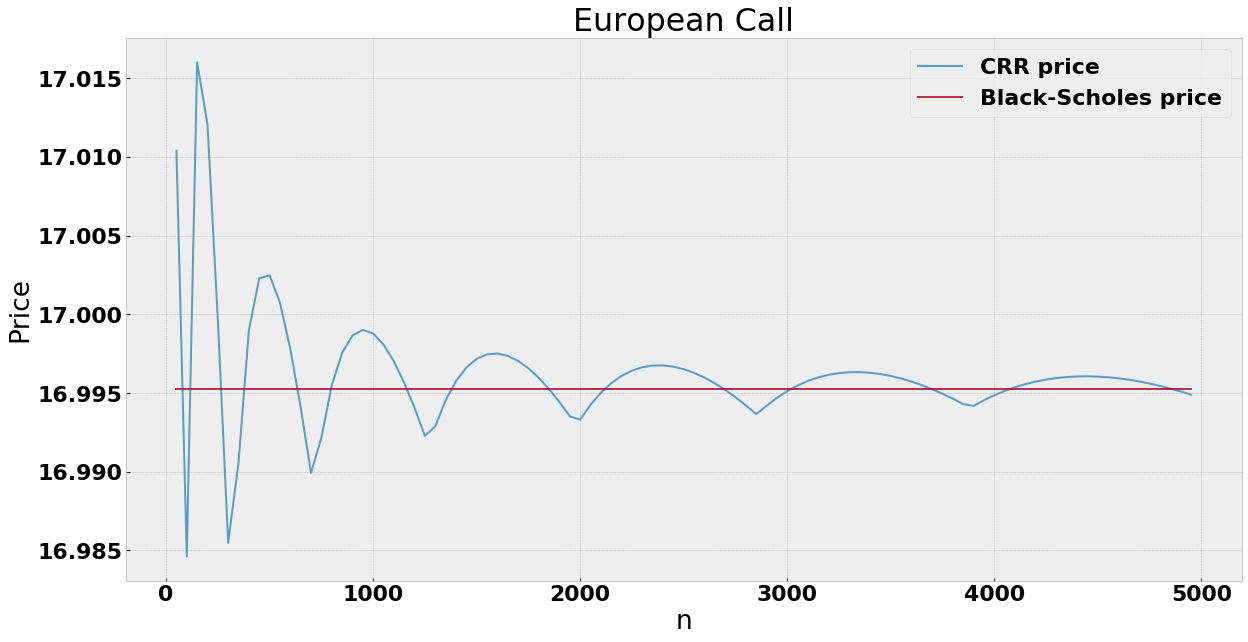

In [132]:
bs = Black_Scholes(T, S, r, sigma, K) #Black-Scholes price
a = len(Price_n50)
bs = [bs]*a
fig = plt.figure(figsize = [20,10])
ax = plt.subplot(111)
plt.plot(Ns, Price_n50, alpha = 0.8, markersize = 4, label = "CRR price")
plt.plot(Ns, bs, alpha = 0.8, markersize = 4, label = "Black-Scholes price")
plt.title('European Call')
plt.xlabel("n")
plt.ylabel("Price")
ax.legend()
plt.show()

We see that when *n* converges to infinity, the price converges to the price from the Black-Scholes model.

# 2.

### Simple Monte Carlo

In [1084]:
#Market parameters
S = 100
sigma = 1
T = 10
r = 0.1
K = 90

In [1085]:
def ST(S, T, sigma, r):
    Z = np.random.randn()
    return S*math.exp((sigma*math.sqrt(T)*Z) + (r-(sigma**2)/2)*T)

In [1086]:
def MC_n(n, S=S, T = T, sigma = sigma, r = r, K = K):
    samples = np.array([.0]*n)
    for i in range(n):
        samples[i] = max(ST(S,T,sigma, r) - K, 0)*math.exp(-r*T)
    mean = np.mean(samples)
    return (samples, mean)
    
        

In [9]:
def Var_est(samples, mean):
    return (1/(samples.shape[0]-1))*np.sum(np.square(samples-mean))

In [1088]:
res1 = MC_n(1000000)

In [1089]:
print("Error for 1 mln samples: " + np.array2string(abs(Black_Scholes(T, S, r, sigma, K)-res1[1])))
print("Actual: " + np.array2string(Black_Scholes(T, S, r, sigma, K)))
print("Estimated: " + np.array2string(res1[1]))
print("Estimated variance: " + np.array2string(Var_est(res1[0], res1[1])))

Error for 1 mln samples: 4.64180904
Actual: 93.71332502
Estimated: 89.07151597
Estimated variance: 18565239.34106302


In [1090]:
#Calculation mean for different n's
est1 = []
var = []
ns = np.arange(100,100000, 1000)
for i in ns:
    est1.append(MC_n(i)[1])
    var.append(Var_est(MC_n(i)[0], MC_n(i)[1]))
print("Mean variance: " + np.array2string(np.mean(var)))

Mean variance: 19414472.77362238


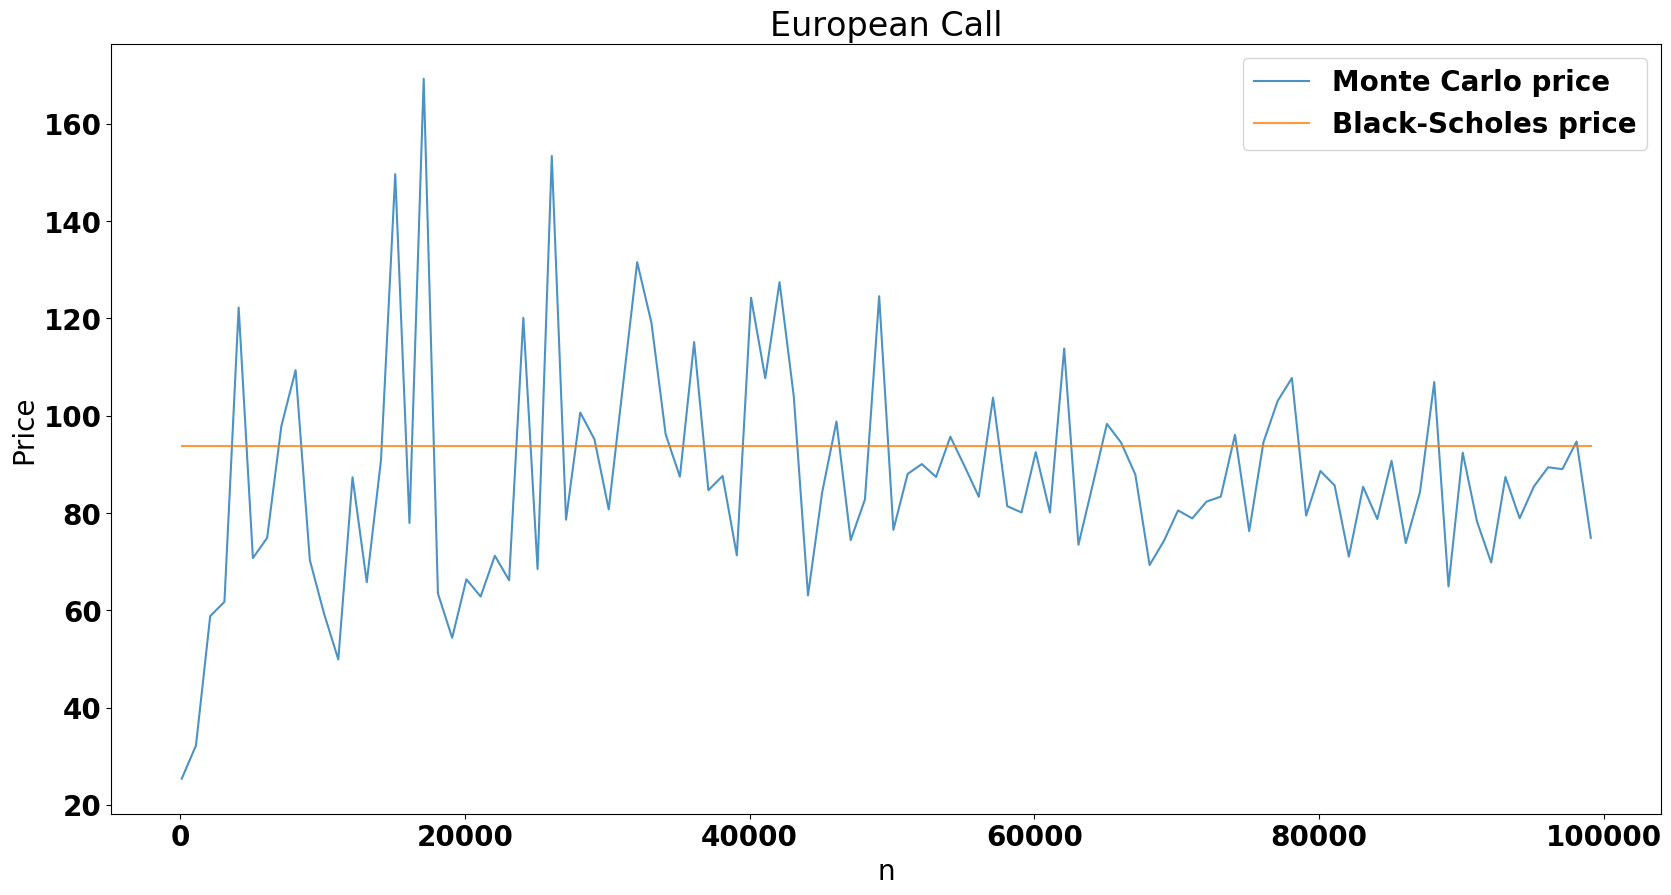

In [1091]:
bs = Black_Scholes(T, S, r, sigma, K) #Black-Scholes price
a = len(est1)
bs = [bs]*a
fig = plt.figure(figsize = [20,10])
ax = plt.subplot(111)
plt.plot(ns, est1, alpha = 0.8, markersize = 4, label = "Monte Carlo price")
plt.plot(ns, bs, alpha = 0.8, markersize = 4, label = "Black-Scholes price")
plt.title('European Call')
plt.xlabel("n")
plt.ylabel("Price")
ax.legend()
plt.show()

###  a) Control variates method

In [1092]:
def MC_n_CVM(n, S=S, T = T, sigma = sigma, r = r, K = K):
    samples = np.array([.0]*n)
    u_k = S
    for i in range(n):
        S_T = ST(S,T,sigma, r)
        samples[i] = math.exp(-r*T)*(max(S_T - K, 0) - S_T) + u_k
    mean = np.mean(samples) 
    return (samples, mean)

In [1093]:
res2 = MC_n_CVM(1000000)

In [1094]:
print("Error for 1 mln samples: " + np.array2string(abs(Black_Scholes(T, S, r, sigma, K)-res2[1])))
print("Actual: " + np.array2string(Black_Scholes(T, S, r, sigma, K)))
print("Estimated: " + np.array2string(res2[1]))
print("Estimated variance: " + np.array2string(Var_est(res2[0], res2[1])))

Error for 1 mln samples: 0.00207405
Actual: 93.71332502
Estimated: 93.71125096
Estimated variance: 118.73770581


Variance actually decreased a lot compared to the standard Monte Carlo.

In [1095]:
#Calculation mean for different n's
est2 = []
var2 = []
ns = np.arange(100,100000, 1000)
for i in ns:
    est2.append(MC_n_CVM(i)[1])
    var2.append(Var_est(MC_n_CVM(i)[0], MC_n_CVM(i)[1]))
print("Mean variance: " + np.array2string(np.mean(var2)))
    

Mean variance: 118.98200699


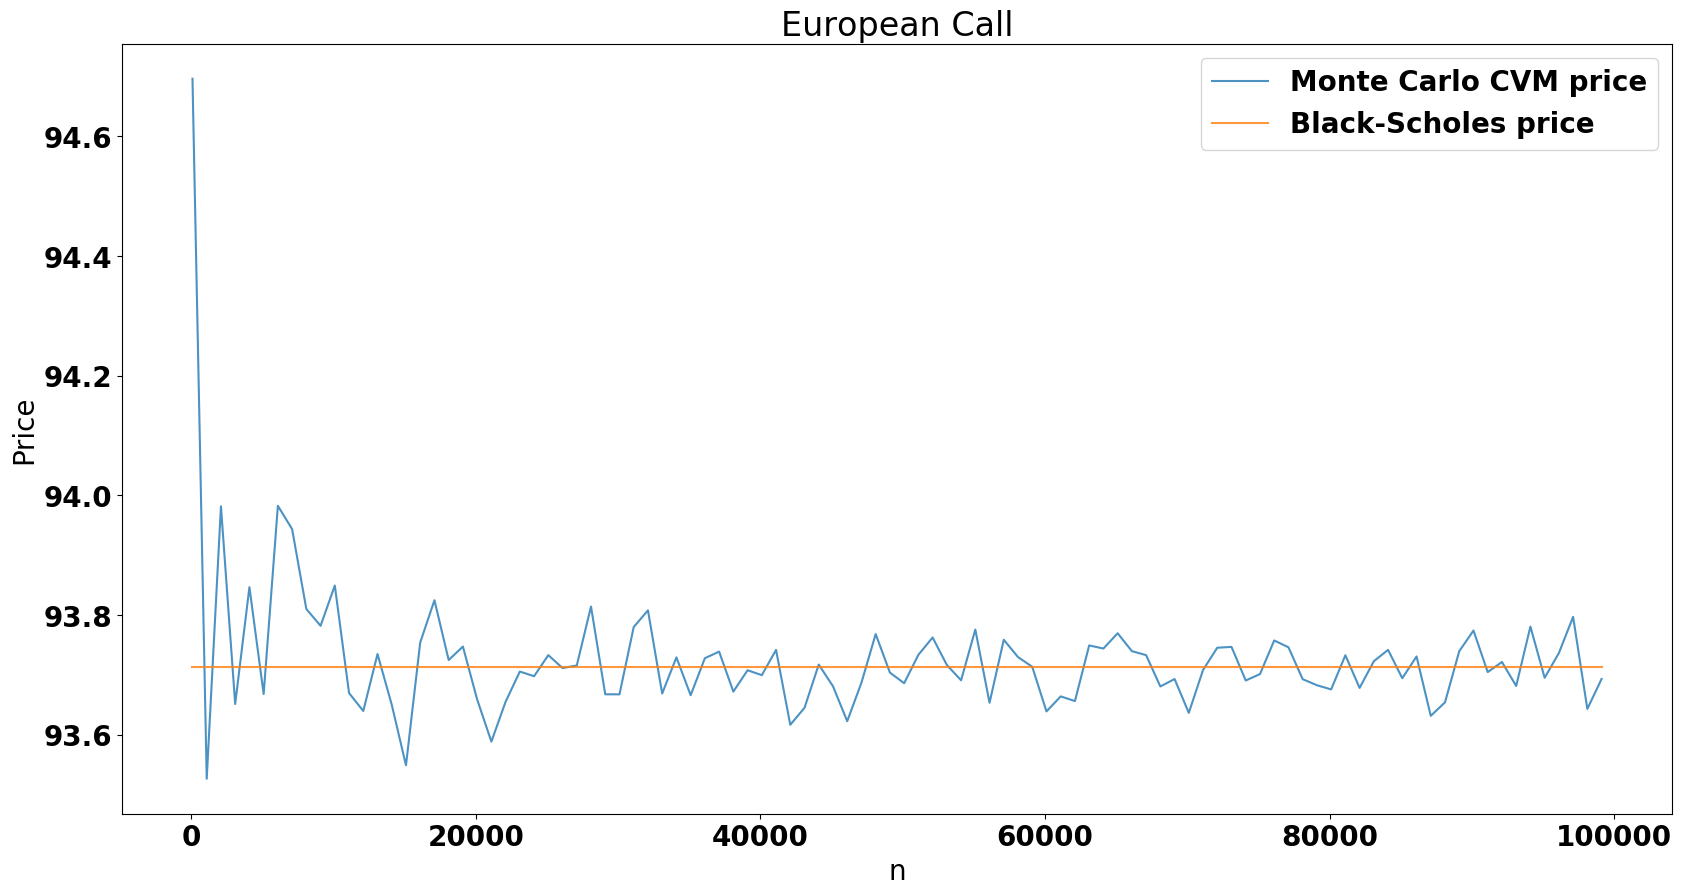

In [1096]:
bs = Black_Scholes(T, S, r, sigma, K) #Black-Scholes price
a = len(est2)
bs = [bs]*a
fig = plt.figure(figsize = [20,10])
ax = plt.subplot(111)
plt.plot(ns, est2, alpha = 0.8, markersize = 4, label = "Monte Carlo CVM price")
plt.plot(ns, bs, alpha = 0.8, markersize = 4, label = "Black-Scholes price")
plt.title('European Call')
plt.xlabel("n")
plt.ylabel("Price")
ax.legend()
plt.show()

## b) Turbo Control variates method

In [1097]:
def MC_n_TCVM(n, S=S, T = T, sigma = sigma, r = r, K = K):
    samples = np.array([.0]*n)
    X_is = np.array([.0]*n)
    Y_is = np.array([.0]*n)
    for i in range(n):
        S_T = ST(S,T,sigma, r)
        Y_is[i] = S_T
        X_is[i] = math.exp(-r*T)*max(S_T - K, 0)
    b_hat = np.sum((X_is - np.mean(X_is))*(Y_is-np.mean(Y_is))) / (np.sum(np.square(Y_is-np.mean(Y_is))))
    u_k = b_hat*S*math.exp(r*T)                                                              
    for i in range(n):
        samples[i] = X_is[i] - b_hat*Y_is[i] + u_k
    mean = np.mean(samples) 
    return (samples, mean)

In [1098]:
res3 = MC_n_TCVM(1000000)

In [1099]:
print("Error for 1 mln samples: " + np.array2string(abs(Black_Scholes(T, S, r, sigma, K)-res3[1])))
print("Actual: " + np.array2string(Black_Scholes(T, S, r, sigma, K)))
print("Estimated: " + np.array2string(res3[1]))
print("Estimated variance: " + np.array2string(Var_est(res3[0], res3[1])))

Error for 1 mln samples: 0.01882106
Actual: 93.71332502
Estimated: 93.69450396
Estimated variance: 118.88920692


In [1100]:
#Calculation mean for different n's
est3 = []
var3 = []
ns = np.arange(100,100000, 1000)
for i in ns:
    est_i = MC_n_TCVM(i)
    est3.append(est_i[1])
    var3.append(Var_est(est_i[0], est_i[1]))
print("Mean variance: " + np.array2string(np.mean(var3)))

Mean variance: 116.94322508


The variance is a little lower for these parameters compared to the previousl method of controlling variates

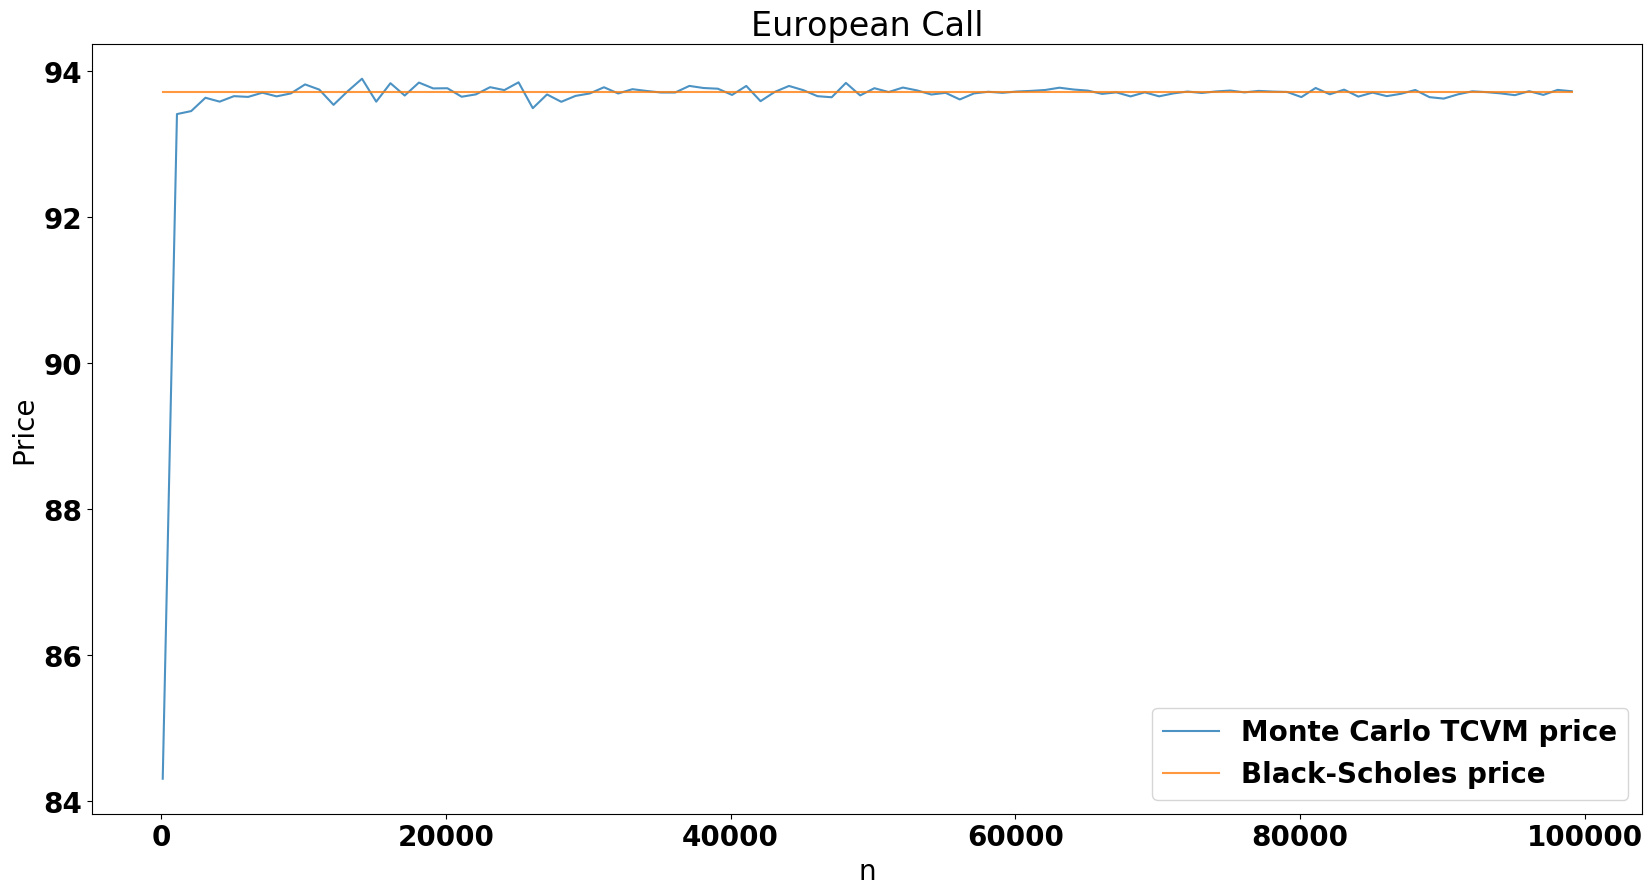

In [1101]:
bs = Black_Scholes(T, S, r, sigma, K) #Black-Scholes price
a = len(est3)
bs = [bs]*a
fig = plt.figure(figsize = [20,10])
ax = plt.subplot(111)
plt.plot(ns, est3, alpha = 0.8, markersize = 4, label = "Monte Carlo TCVM price")
plt.plot(ns, bs, alpha = 0.8, markersize = 4, label = "Black-Scholes price")
plt.title('European Call')
plt.xlabel("n")
plt.ylabel("Price")
ax.legend()
plt.show()

## c) Method of antithetical variates

In [898]:
def ST_prim(S = S, T = T, sigma = sigma, r = r):
    Z = np.random.randn()
    ST = S*math.exp((sigma*math.sqrt(T)*Z) + (r-(sigma**2)/2)*T)
    ST_prim = S*math.exp((sigma*math.sqrt(T)*(-Z)) + (r-(sigma**2)/2)*T)
    return (ST, ST_prim)

In [899]:
def MC_n_AVM(n, S=S, T = T, sigma = sigma, r = r, K = K):
    samples = np.array([.0]*n)
    for i in range(n):
        ST = ST_prim()
        samples[i] = math.exp(-r*T)*(max(ST[0]-K,0) + max(ST[1]-K,0))/2
    mean = np.mean(samples)
    return (samples, mean)

In [893]:
res4= MC_n_AVM(1000000)

In [894]:
print("Error for 1 mln samples: " + np.array2string(abs(Black_Scholes(T, S, r, sigma, K)-res4[1])))
print("Actual: " + np.array2string(Black_Scholes(T, S, r, sigma, K)))
print("Estimated: " + np.array2string(res4[1]))
print("Estimated variance: " + np.array2string(Var_est(res4[0], res4[1])))

Error for 1 mln samples: 3.37941198
Actual: 93.71332502
Estimated: 97.092737
Estimated variance: 30913452.55382139


In [897]:
#Calculation mean for different n's
est4 = []
var4 = []
ns = np.arange(100,100000, 1000)
for i in ns:
    est_i = MC_n_AVM(i)
    est4.append(est_i[1])
    var4.append(Var_est(est_i[0], est_i[1]))
print("Mean variance: " + np.array2string(np.mean(var4)))

Mean variance: 26150437.73960015


We received better variance compared to the standard Monte Carlo, which we expected.

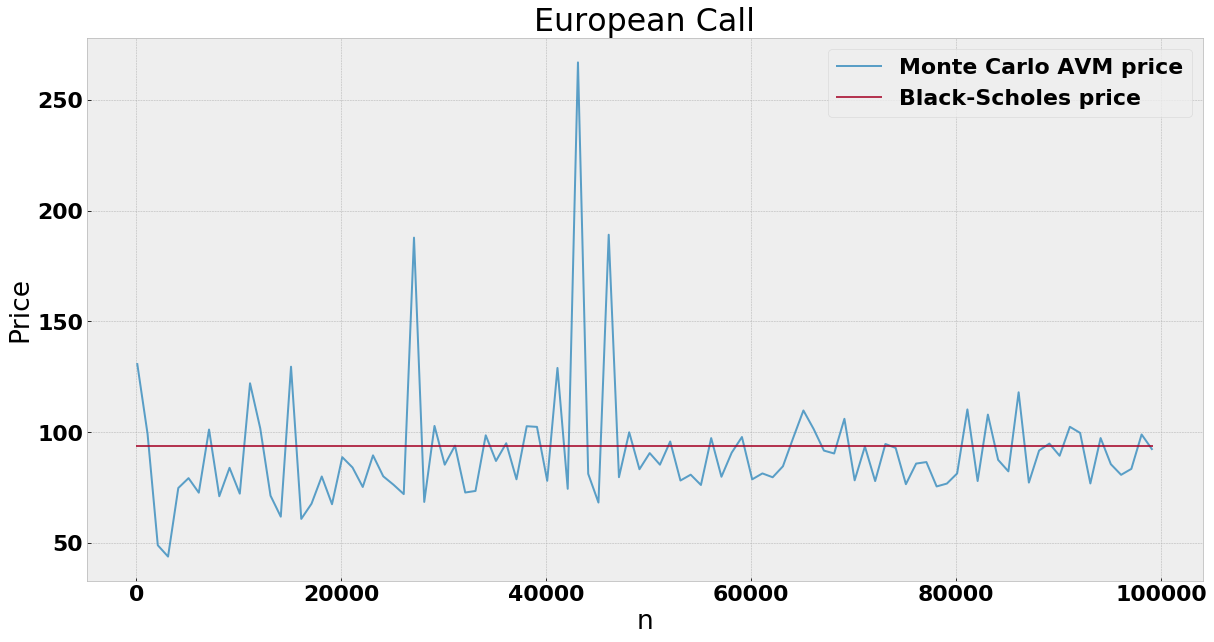

In [900]:
bs = Black_Scholes(T, S, r, sigma, K) #Black-Scholes price
a = len(est4)
bs = [bs]*a
fig = plt.figure(figsize = [20,10])
ax = plt.subplot(111)
plt.plot(ns, est4, alpha = 0.8, markersize = 4, label = "Monte Carlo AVM price")
plt.plot(ns, bs, alpha = 0.8, markersize = 4, label = "Black-Scholes price")
plt.title('European Call')
plt.xlabel("n")
plt.ylabel("Price")
ax.legend()
plt.show()

## d) Stratified Monte Carlo

In [901]:
def ST_i(k, i, S = S, T = T, sigma = sigma, r = r):
    U = np.random.uniform()
    Z = norm._ppf((i - 1 + U)/k)
    return S*math.exp((sigma*math.sqrt(T)*Z) + (r-(sigma**2)/2)*T)

In [902]:
def MC_n_STR(n, S=S, T = T, sigma = sigma, r = r, K = K, k = 1000):
    samples = np.array([.0]*n)
    for j in range(n):
        i = j%k + 1
        samples[j] = math.exp(-r*T)*max(ST_i(k,i)-K,0) 
    mean = np.mean(samples)
    return (samples, mean)

In [903]:
k_s = [10,100,1000,10000,100000,1000000]
for k in k_s:
    res5= MC_n_STR(1000000, k = k)
    print("Estimated variance for k =  "+ str(k) + ": " + np.array2string(Var_est(res5[0], res5[1])))

Estimated variance for k =  10: 20634097.54153028
Estimated variance for k =  100: 27620916.97780032
Estimated variance for k =  1000: 36433511.40523206
Estimated variance for k =  10000: 18516770.87453705
Estimated variance for k =  100000: 19413675.04005802
Estimated variance for k =  1000000: 73220926.84534235


We achieved the best result for k equal to 10 000, but it's quite random.

In [904]:
res5= MC_n_STR(1000000, k = 10000)
print("Error for 1 mln samples: " + np.array2string(abs(Black_Scholes(T, S, r, sigma, K)-res5[1])))
print("Actual: " + np.array2string(Black_Scholes(T, S, r, sigma, K)))
print("Estimated: " + np.array2string(res5[1]))
print("Estimated variance: " + np.array2string(Var_est(res5[0], res5[1])))

Error for 1 mln samples: 0.97052802
Actual: 93.71332502
Estimated: 92.742797
Estimated variance: 22485984.60007623


We received results similar to antithetical variates version.

In [905]:
#Calculation mean for different n's
est5 = []
var5 = []
ns = np.arange(100,100000, 1000)
for i in ns:
    est_i = MC_n_STR(i, k = i/10)
    est5.append(est_i[1])
    var5.append(Var_est(est_i[0], est_i[1]))
print("Mean variance: " + np.array2string(np.mean(var5)))

Mean variance: 17141845.14446997


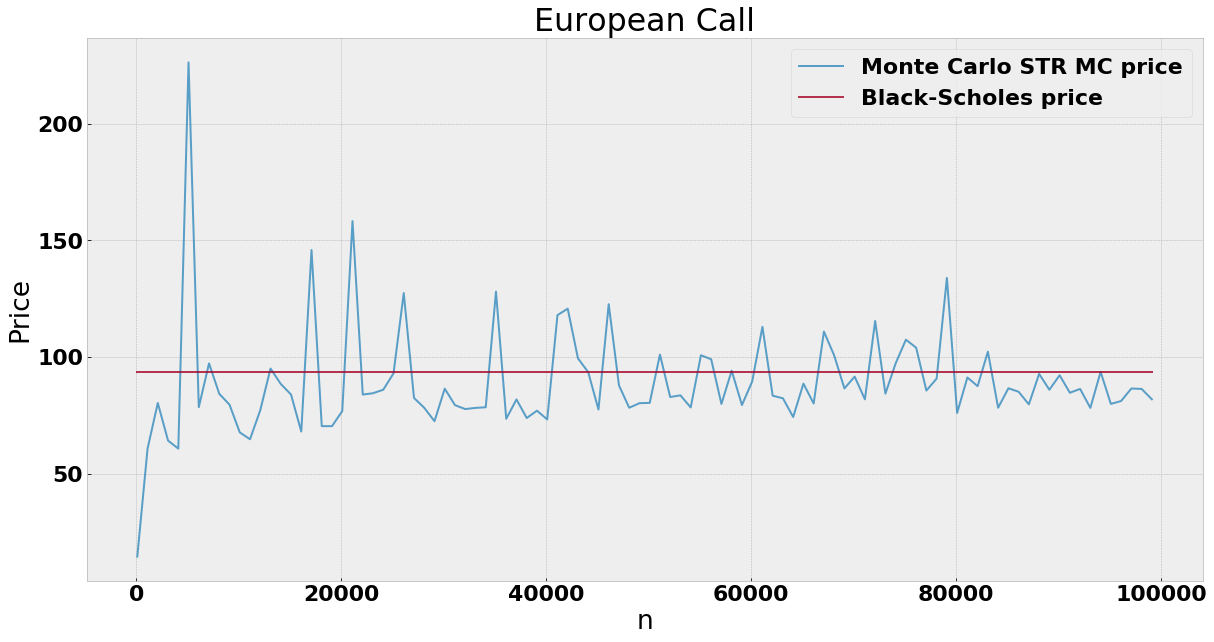

In [906]:
bs = Black_Scholes(T, S, r, sigma, K) #Black-Scholes price
a = len(est5)
bs = [bs]*a
fig = plt.figure(figsize = [20,10])
ax = plt.subplot(111)
plt.plot(ns, est5, alpha = 0.8, markersize = 4, label = "Monte Carlo STR MC price")
plt.plot(ns, bs, alpha = 0.8, markersize = 4, label = "Black-Scholes price")
plt.title('European Call')
plt.xlabel("n")
plt.ylabel("Price")
ax.legend()
plt.show()

## e) Importance Sampling Monte Carlo

In [1102]:
def ST_Y(mi, S = S, T = T, sigma = sigma, r = r):
    Y = np.random.normal(mi, math.sqrt(T))
    return (S*math.exp((sigma*Y) + (r-(sigma**2)/2)*T), Y)

In [1103]:
def MC_n_IS(n, S=S, T = T, sigma = sigma, r = r, K = K, mi = 0):
    samples = np.array([.0]*n)
    for i in range(n):
        ST, Y = ST_Y(mi)
        f_Wt = (math.exp(-(Y/math.sqrt(T))**2/2)/math.sqrt(2*math.pi))/math.sqrt(T)    #norm._pdf(Y, 0, math.sqrt(T))
        f_Y =  (math.exp(-((Y-mi)/math.sqrt(T))**2/2)/math.sqrt(2*math.pi))/math.sqrt(T)   #norm._pdf(Y, mi, math.sqrt(T))
        samples[i] = max(ST - K, 0) * math.exp(-r*T) * (f_Wt/f_Y)
    mean = np.mean(samples)
    return (samples, mean)

In [911]:
mi_s = [0, 0.1, 1, 5, 10, 15, 20, 25]
for mi in mi_s:
    res6= MC_n_IS(1000000, mi = mi)
    print("Estimated variance for mi =  "+ str(mi) + ": " + np.array2string(Var_est(res6[0], res6[1])))

Estimated variance for mi =  0: 10903526.72244409
Estimated variance for mi =  0.1: 6752584.21395865
Estimated variance for mi =  1: 4807260.41710842
Estimated variance for mi =  5: 103066.853809
Estimated variance for mi =  10: 356.4086634
Estimated variance for mi =  15: 46516.60917554
Estimated variance for mi =  20: 12543510.21137886
Estimated variance for mi =  25: 15746687.47558506


We were able to get a very good result for mi equal to 10, let's look a little more closely around this point.

In [912]:
mi_s = np.arange(9,12,0.5)
for mi in mi_s:
    res6= MC_n_IS(1000000, mi = mi)
    print("Estimated variance for mi =  "+ str(mi) + ": " + np.array2string(Var_est(res6[0], res6[1])))

Estimated variance for mi =  9.0: 1723.32990242
Estimated variance for mi =  9.5: 798.16071747
Estimated variance for mi =  10.0: 357.67745727
Estimated variance for mi =  10.5: 336.27994316
Estimated variance for mi =  11.0: 714.90027855
Estimated variance for mi =  11.5: 1536.58297289


The best result we get was for mi = 10.5, it is a lot better compared to the standard Monte Carlo.

In [1104]:
res6= MC_n_IS(1000000, mi = 10.5)
print("Error for 1 mln samples: " + np.array2string(abs(Black_Scholes(T, S, r, sigma, K)-res6[1])))
print("Actual: " + np.array2string(Black_Scholes(T, S, r, sigma, K)))
print("Estimated: " + np.array2string(res6[1]))
print("Estimated variance: " + np.array2string(Var_est(res6[0], res6[1])))

Error for 1 mln samples: 0.03468987
Actual: 93.71332502
Estimated: 93.67863514
Estimated variance: 338.89145382


In [1105]:
#Calculation mean for different n's
est6 = []
var6 = []
ns = np.arange(100,100000, 1000)
for i in ns:
    est_i = MC_n_IS(i, mi = 10.5)
    est6.append(est_i[1])
    var6.append(Var_est(est_i[0], est_i[1]))
print("Mean variance: " + np.array2string(np.mean(var6)))

Mean variance: 337.12242631


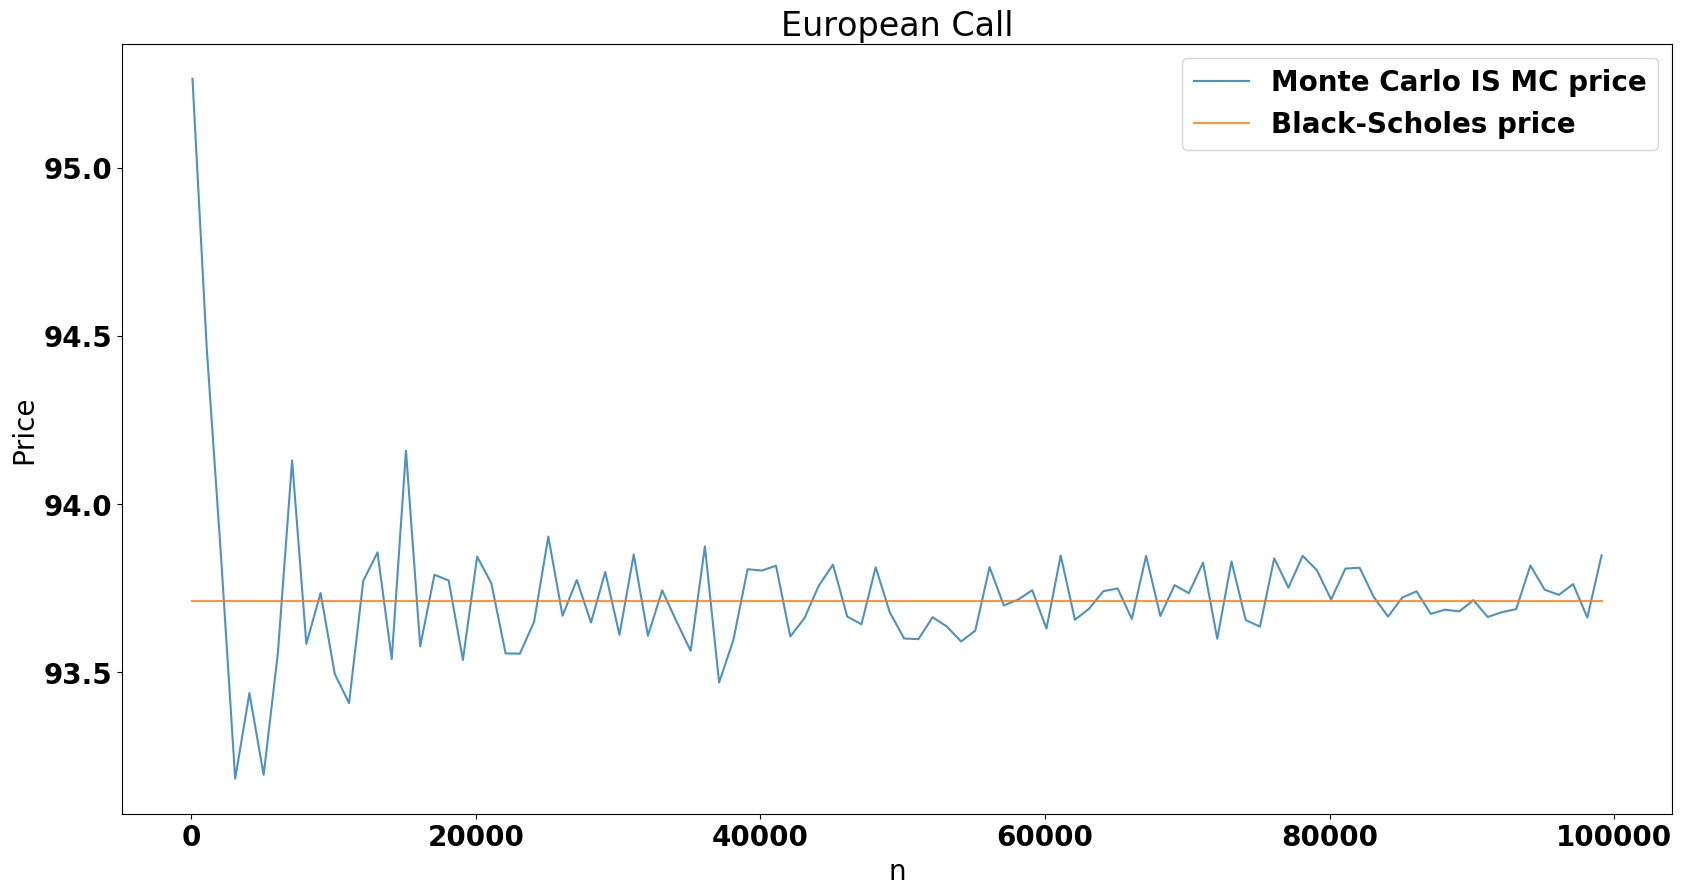

In [1106]:
bs = Black_Scholes(T, S, r, sigma, K) #Black-Scholes price
a = len(est6)
bs = [bs]*a
fig = plt.figure(figsize = [20,10])
ax = plt.subplot(111)
plt.plot(ns, est6, alpha = 0.8, markersize = 4, label = "Monte Carlo IS MC price")
plt.plot(ns, bs, alpha = 0.8, markersize = 4, label = "Black-Scholes price")
plt.title('European Call')
plt.xlabel("n")
plt.ylabel("Price")
ax.legend()
plt.show()

## Summary

### Big ns

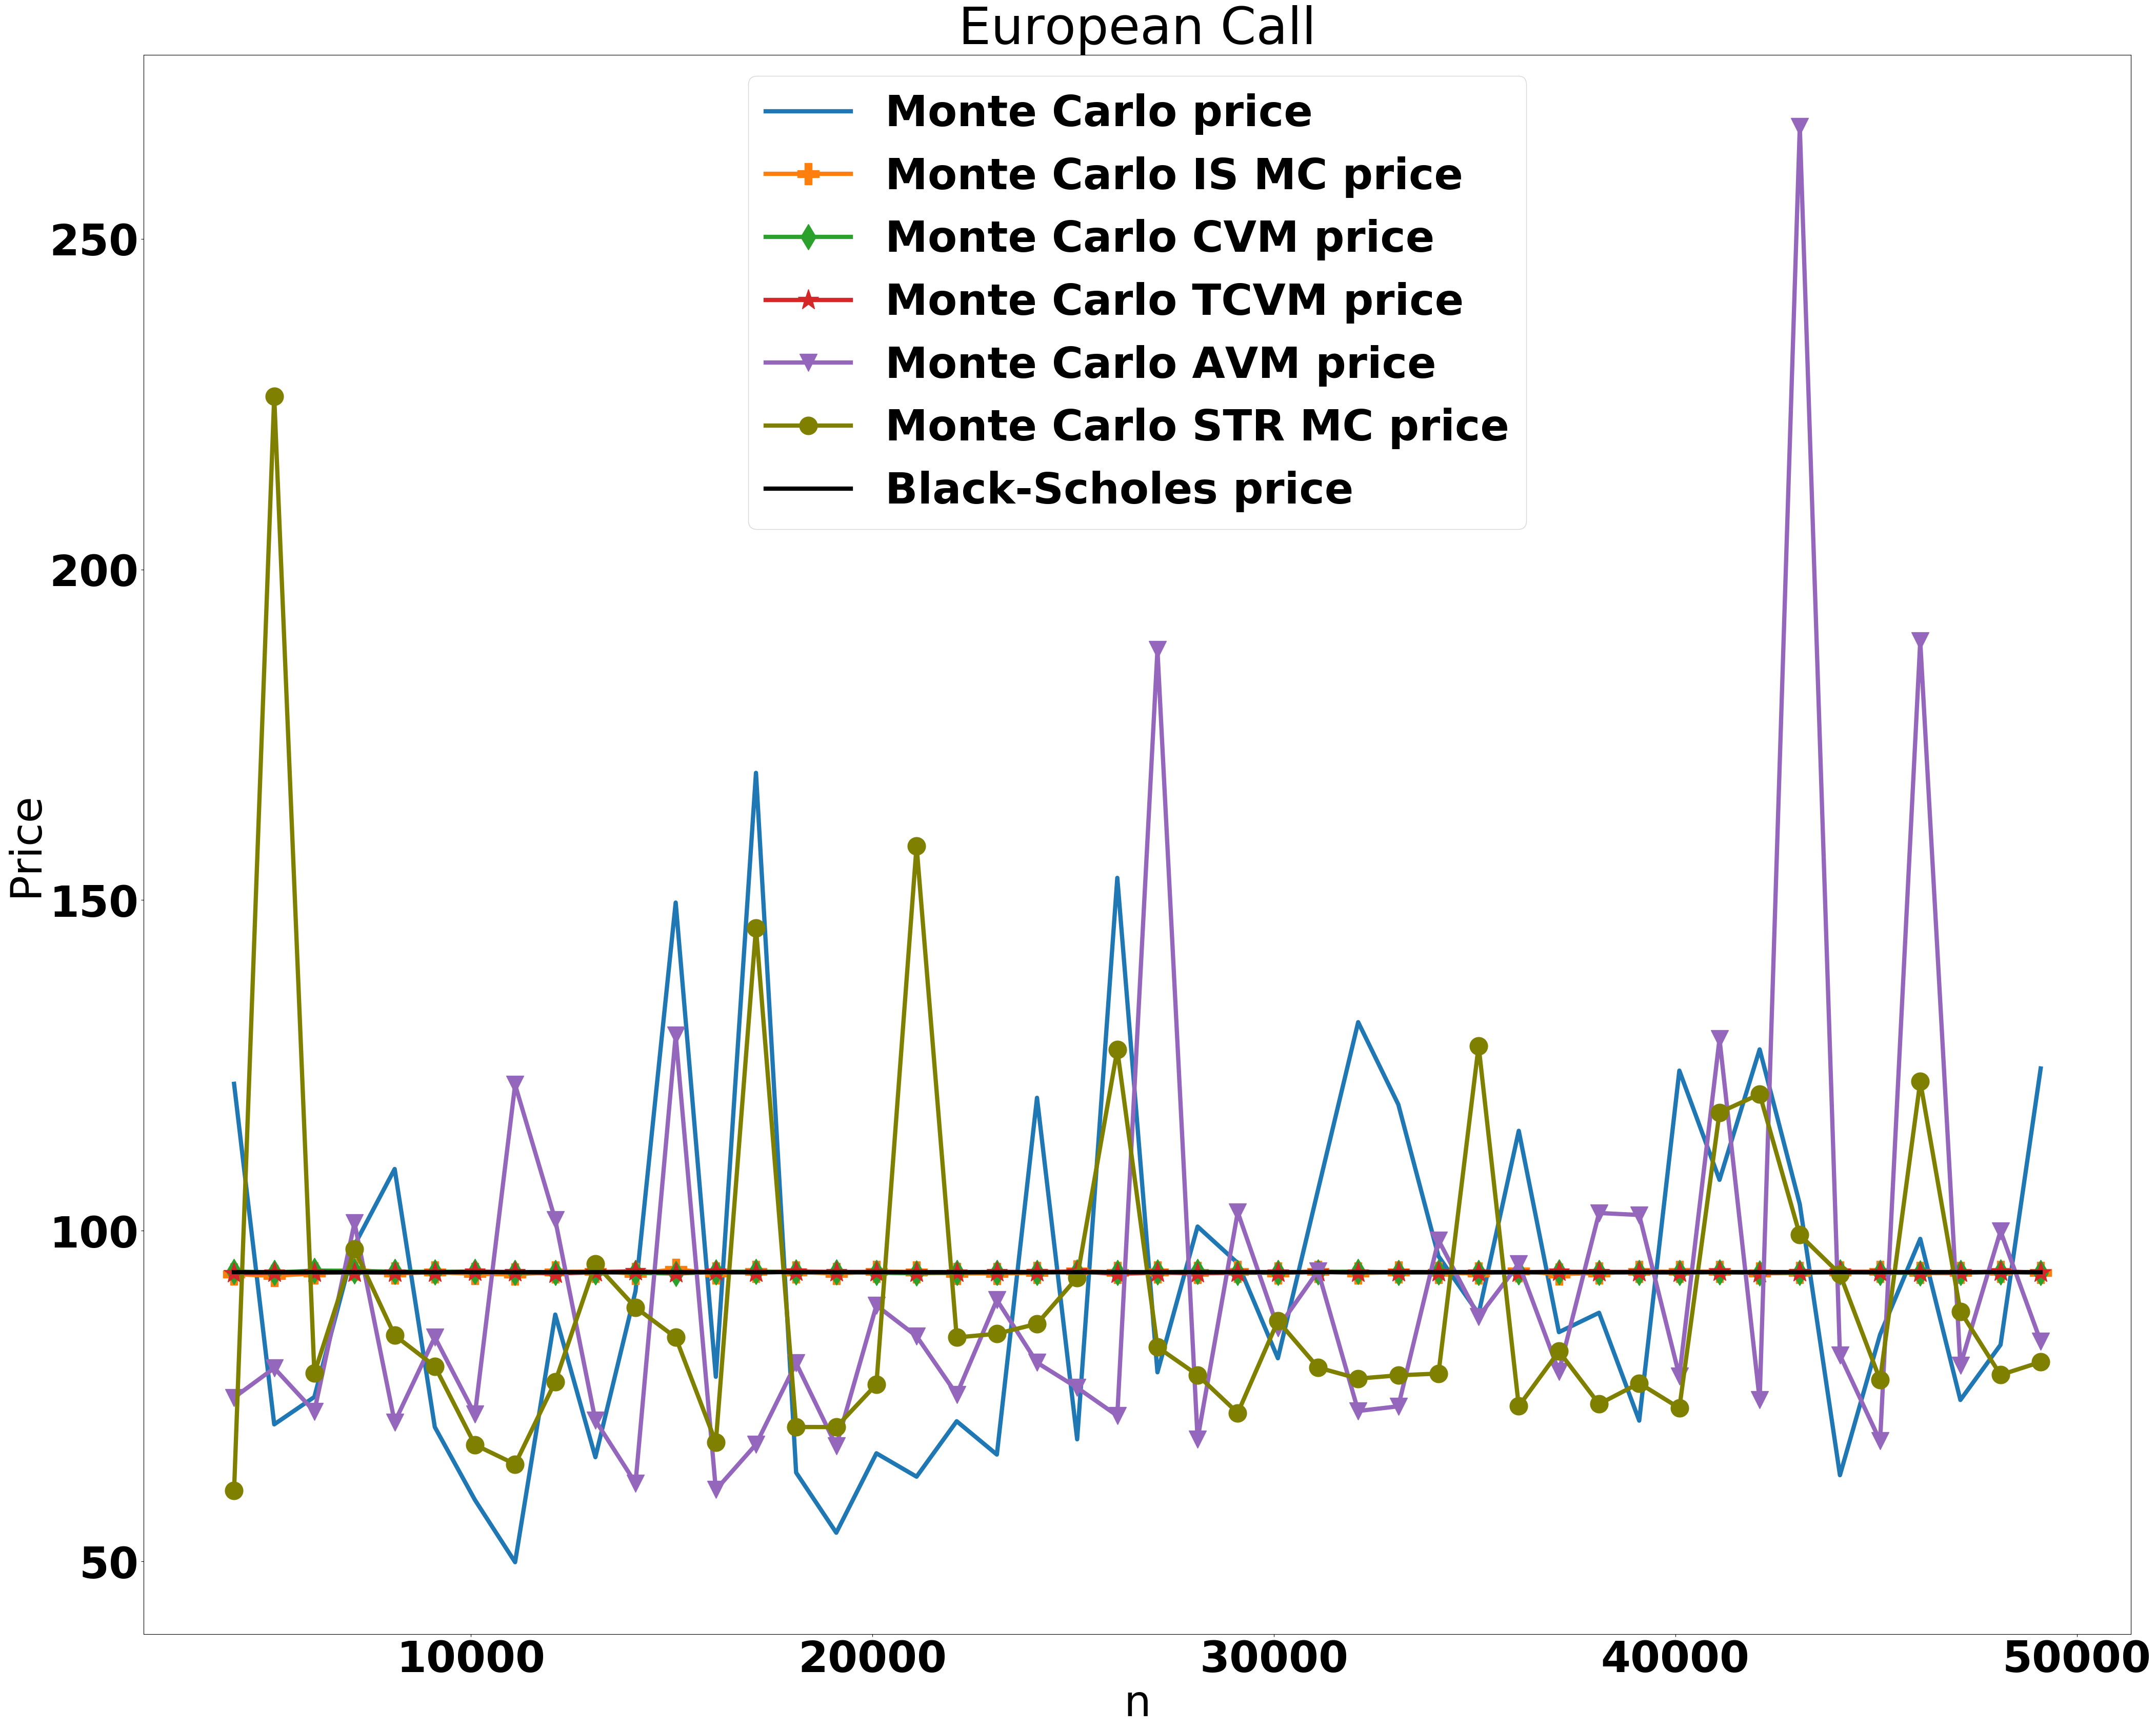

In [1107]:
font = {
        'weight' : 'bold',
        'size'   : 60}

matplotlib.rc('font', **font)
bs = Black_Scholes(T, S, r, sigma, K) #Black-Scholes price
a = len(est6)
bs = [bs]*a
fig = plt.figure(figsize = [50,40])
ax = plt.subplot(111)
plt.plot(ns[4:50], est1[4:50],linewidth=6, markersize = 199, label = "Monte Carlo price")
plt.plot(ns[4:50], est6[4:50],linewidth=6, markersize = 30, marker = "P", label = "Monte Carlo IS MC price")
plt.plot(ns[4:50], est2[4:50],linewidth=6, markersize = 25, marker = "d", label = "Monte Carlo CVM price")
plt.plot(ns[4:50], est3[4:50],linewidth=6, markersize = 30, marker = "*", label = "Monte Carlo TCVM price")
plt.plot(ns[4:50], est4[4:50],linewidth=6, markersize = 25, marker = "v", label = "Monte Carlo AVM price")
plt.plot(ns[4:50], est5[4:50], linewidth=6, markersize = 25, label = "Monte Carlo STR MC price", marker = 'o', color = "olive")
plt.plot(ns[4:50], bs[4:50], linewidth=6,  markersize = 199, label = "Black-Scholes price", color = "black")
plt.title('European Call')
plt.xlabel("n")
plt.ylabel("Price")
ax.legend()
plt.show()

## Best ones

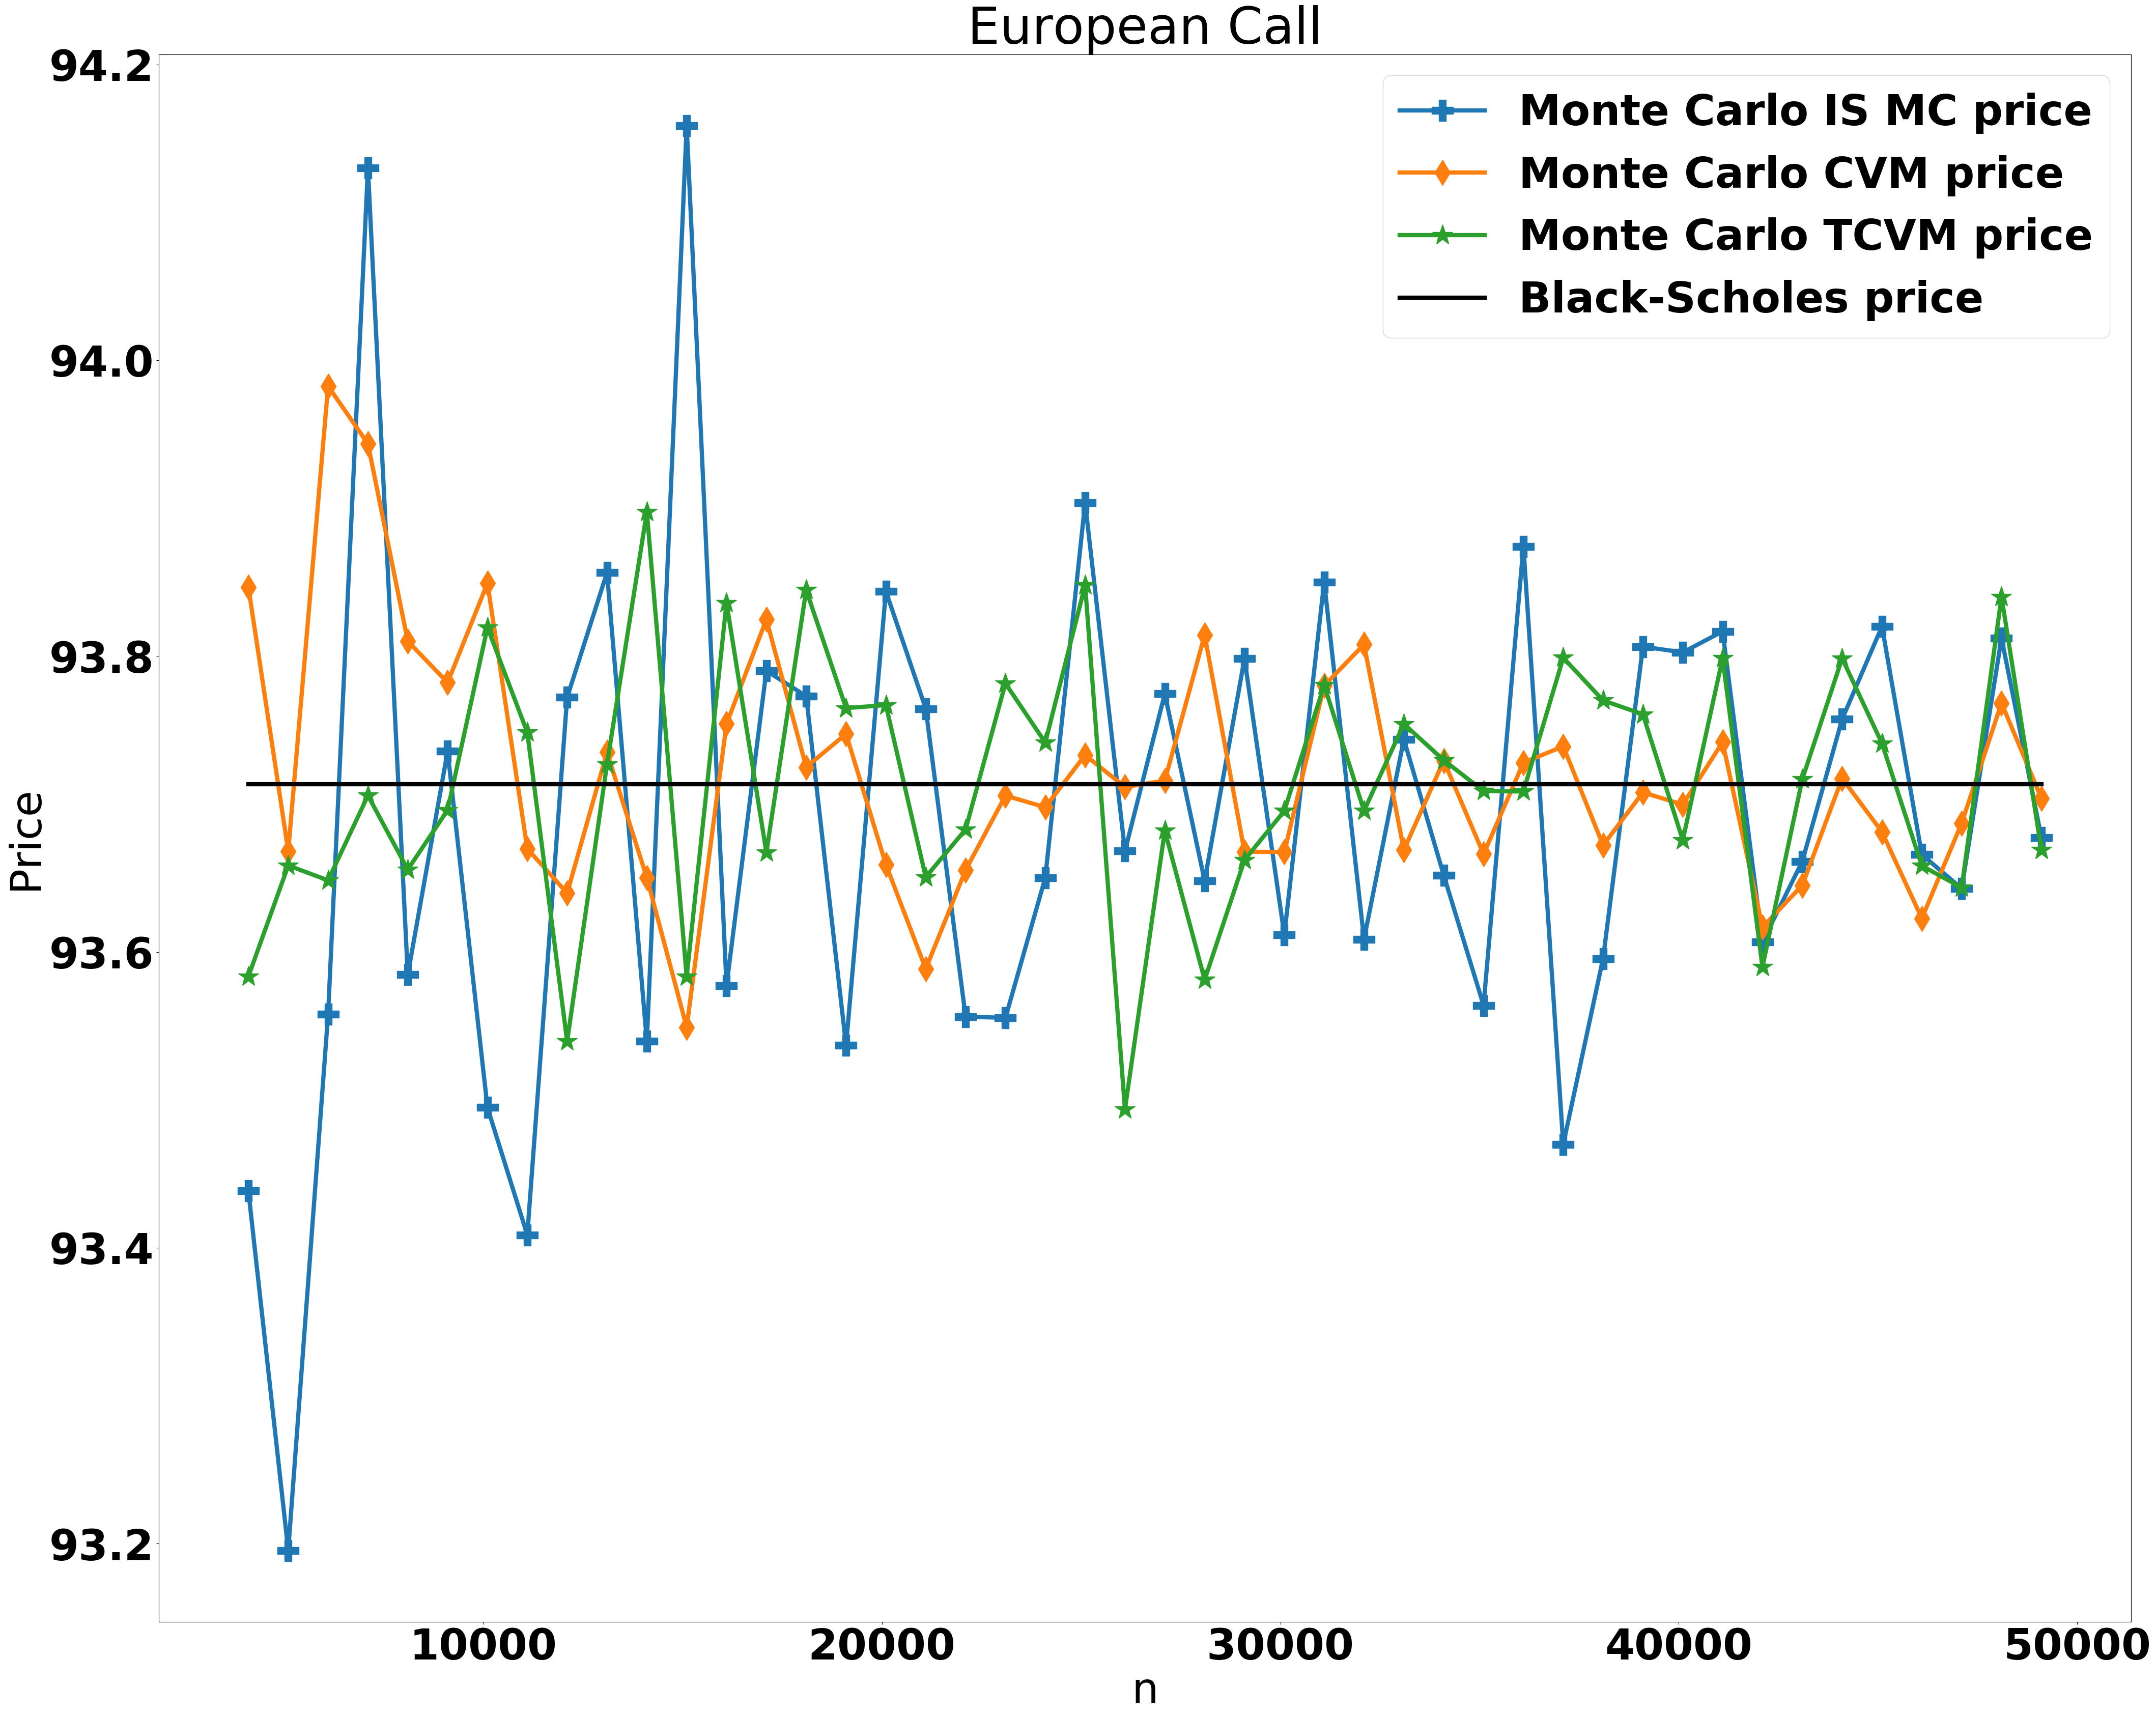

In [1108]:
font = {
        'weight' : 'bold',
        'size'   : 60}

matplotlib.rc('font', **font)
bs = Black_Scholes(T, S, r, sigma, K) #Black-Scholes price
a = len(est6)
bs = [bs]*a
fig = plt.figure(figsize = [50,40])
ax = plt.subplot(111)

plt.plot(ns[4:50], est6[4:50],linewidth=6, markersize = 30, marker = "P", label = "Monte Carlo IS MC price")
plt.plot(ns[4:50], est2[4:50],linewidth=6, markersize = 25, marker = "d", label = "Monte Carlo CVM price")
plt.plot(ns[4:50], est3[4:50],linewidth=6, markersize = 30, marker = "*", label = "Monte Carlo TCVM price")

plt.plot(ns[4:50], bs[4:50], linewidth=6,  markersize = 199, label = "Black-Scholes price", color = "black")
plt.title('European Call')
plt.xlabel("n")
plt.ylabel("Price")
ax.legend()
plt.show()

We can see that for big ns the best methods have significantly overcome the rest, we can see that their variance decreases very much with increasing n. 
However, they are lightly biased.

### Smaller ns

In [1109]:
est1s = []

nss = np.arange(5,1000,10)
for i in nss:
    est1s.append(MC_n(i)[1])


est2s = []

for i in nss:
    est2s.append(MC_n_CVM(i)[1])


est3s = []


for i in nss:
    est_i = MC_n_TCVM(i)
    est3s.append(est_i[1])


est4s = []


for i in nss:
    est_i = MC_n_AVM(i)
    est4s.append(est_i[1])


est5s = []

for i in nss:
    est_i = MC_n_STR(i, k = int(i/10) + 1)
    est5s.append(est_i[1])


est6s = []

for i in nss:
    est_i = MC_n_IS(i, mi = 10.5)
    est6s.append(est_i[1])


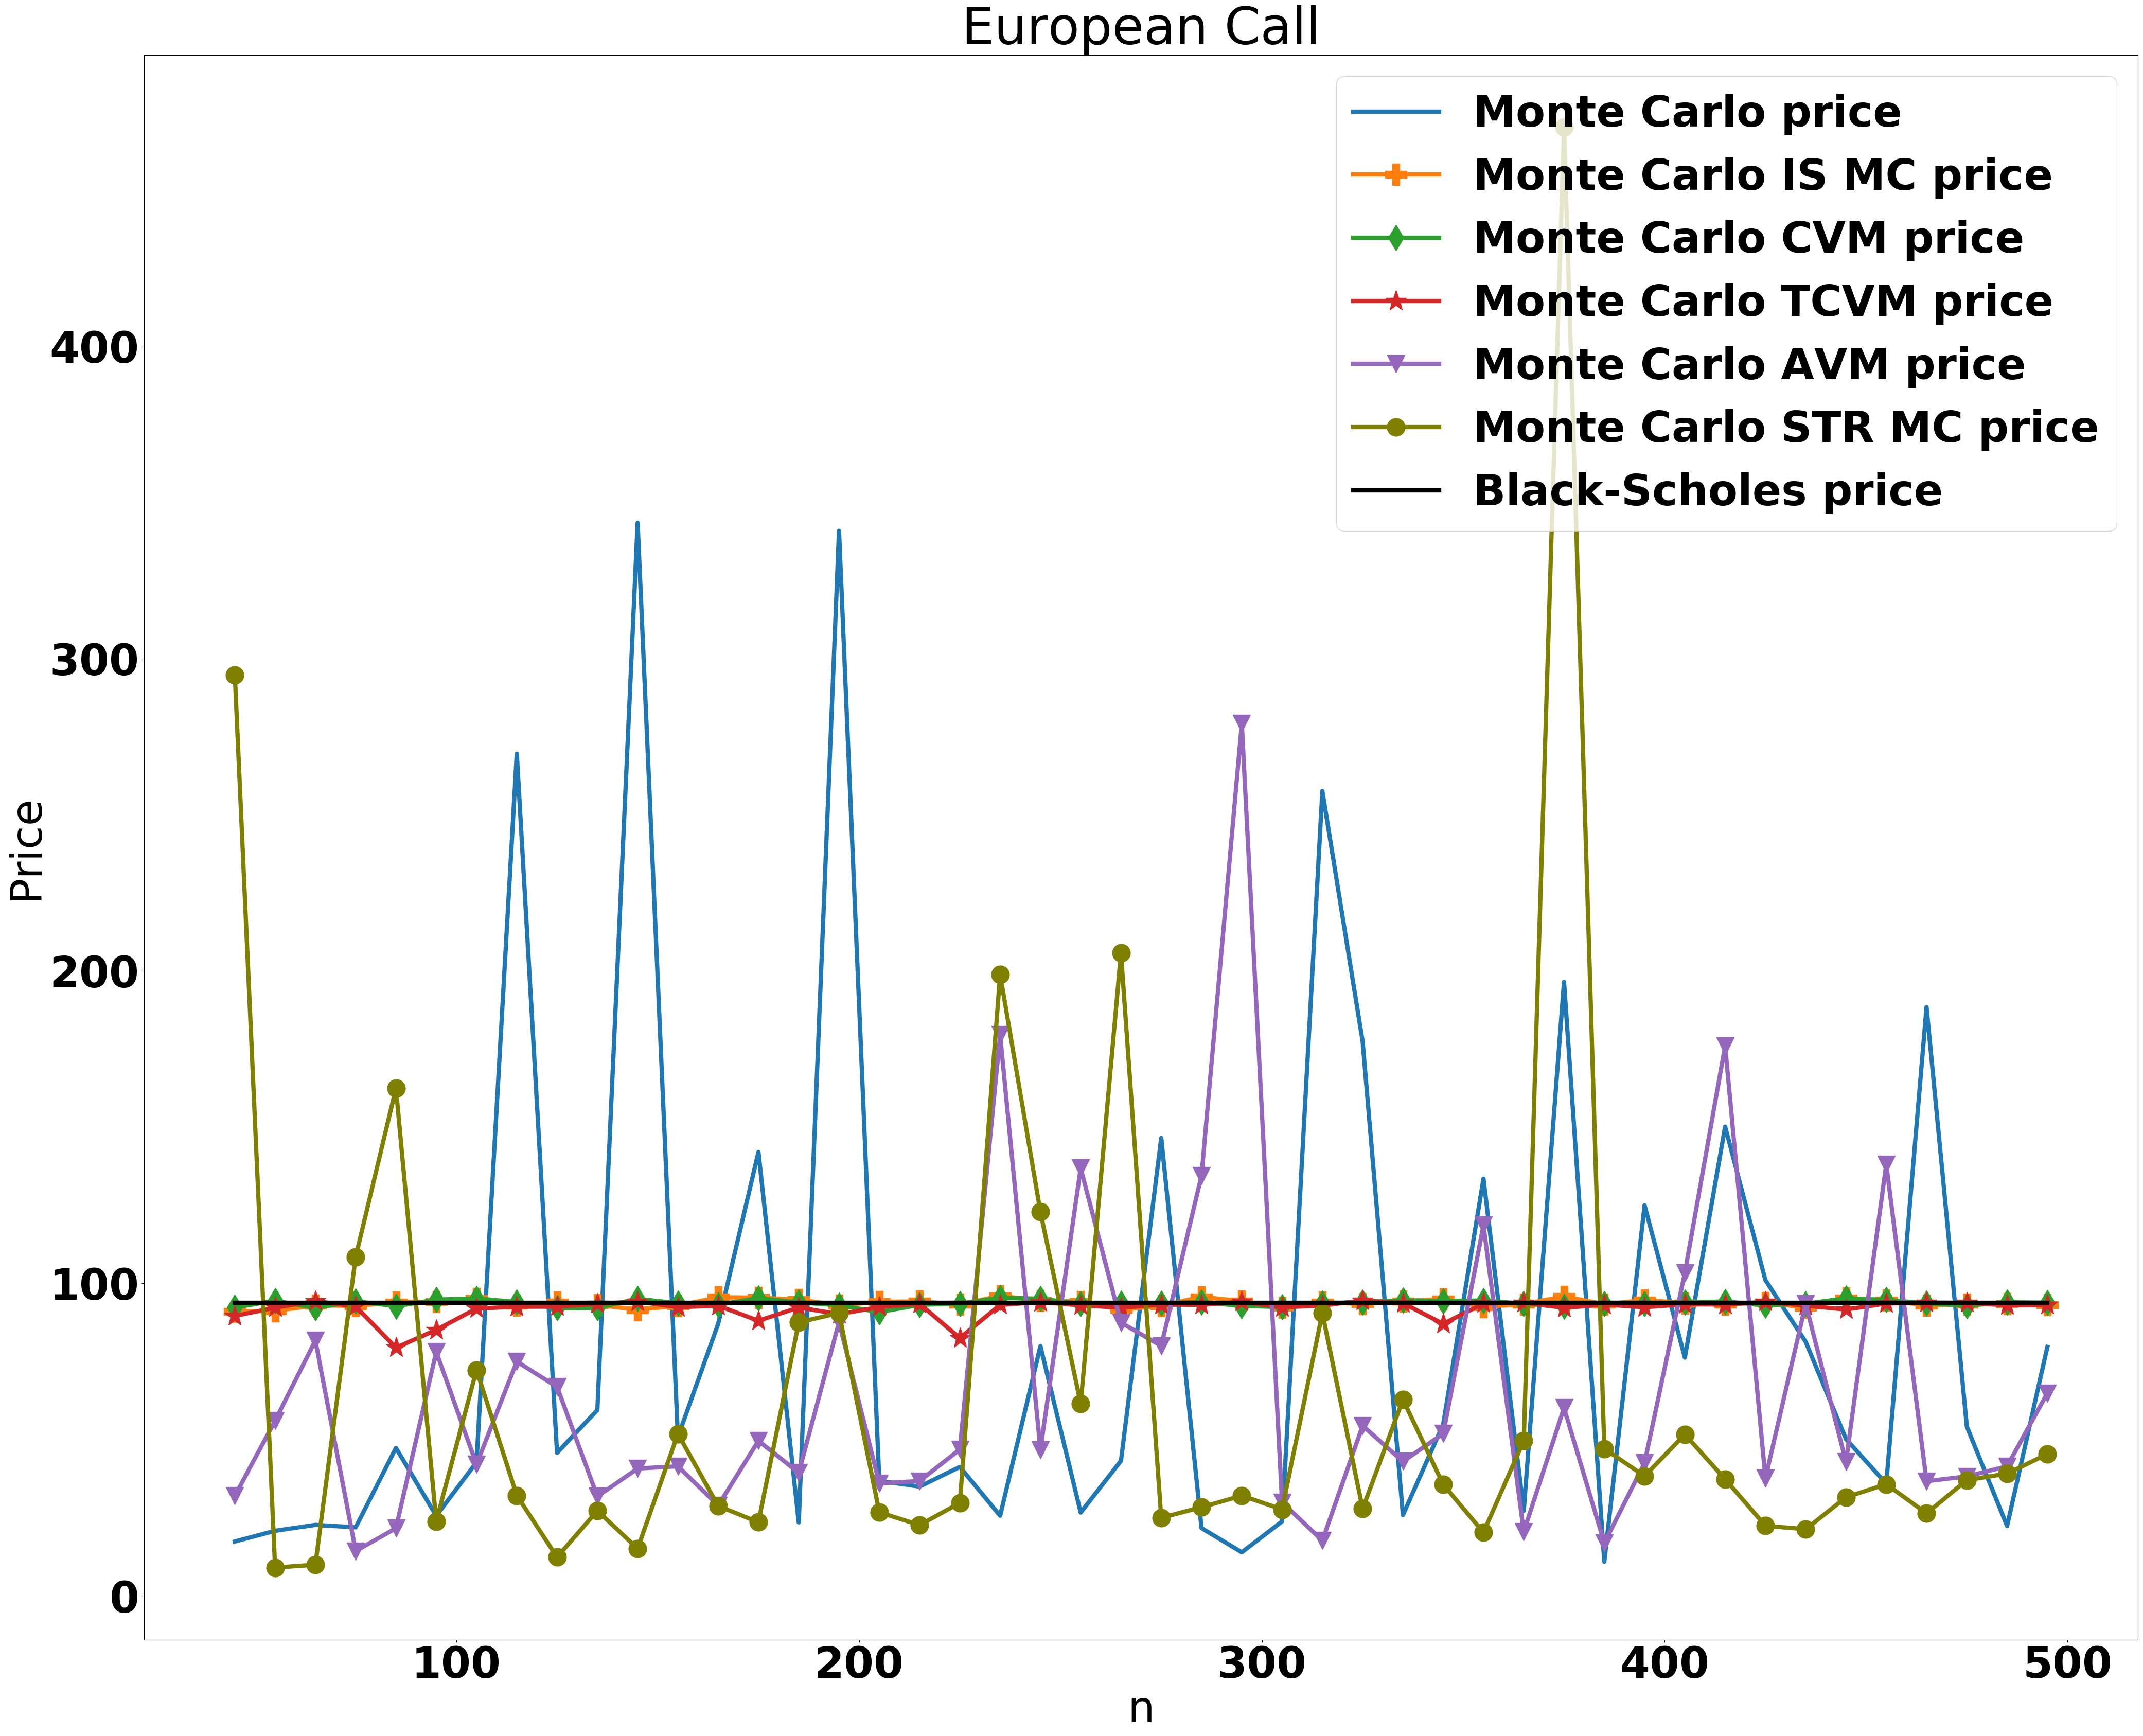

In [1110]:
font = {
        'weight' : 'bold',
        'size'   : 60}

matplotlib.rc('font', **font)
bs = Black_Scholes(T, S, r, sigma, K) #Black-Scholes price
a = len(est6s)
bs = [bs]*a
fig = plt.figure(figsize = [50,40])
ax = plt.subplot(111)
plt.plot(nss[4:50], est1s[4:50],linewidth=6, markersize = 199, label = "Monte Carlo price")
plt.plot(nss[4:50], est6s[4:50],linewidth=6, markersize = 30, marker = "P", label = "Monte Carlo IS MC price")
plt.plot(nss[4:50], est2s[4:50],linewidth=6, markersize = 25, marker = "d", label = "Monte Carlo CVM price")
plt.plot(nss[4:50], est3s[4:50],linewidth=6, markersize = 30, marker = "*", label = "Monte Carlo TCVM price")
plt.plot(nss[4:50], est4s[4:50],linewidth=6, markersize = 25, marker = "v", label = "Monte Carlo AVM price")
plt.plot(nss[4:50], est5s[4:50], linewidth=6, markersize = 25, label = "Monte Carlo STR MC price", marker = 'o', color = "olive")
plt.plot(nss[4:50], bs[4:50], linewidth=6,  markersize = 199, label = "Black-Scholes price", color = "black")
plt.title('European Call')
plt.xlabel("n")
plt.ylabel("Price")
ax.legend()
plt.show()

## Best ones

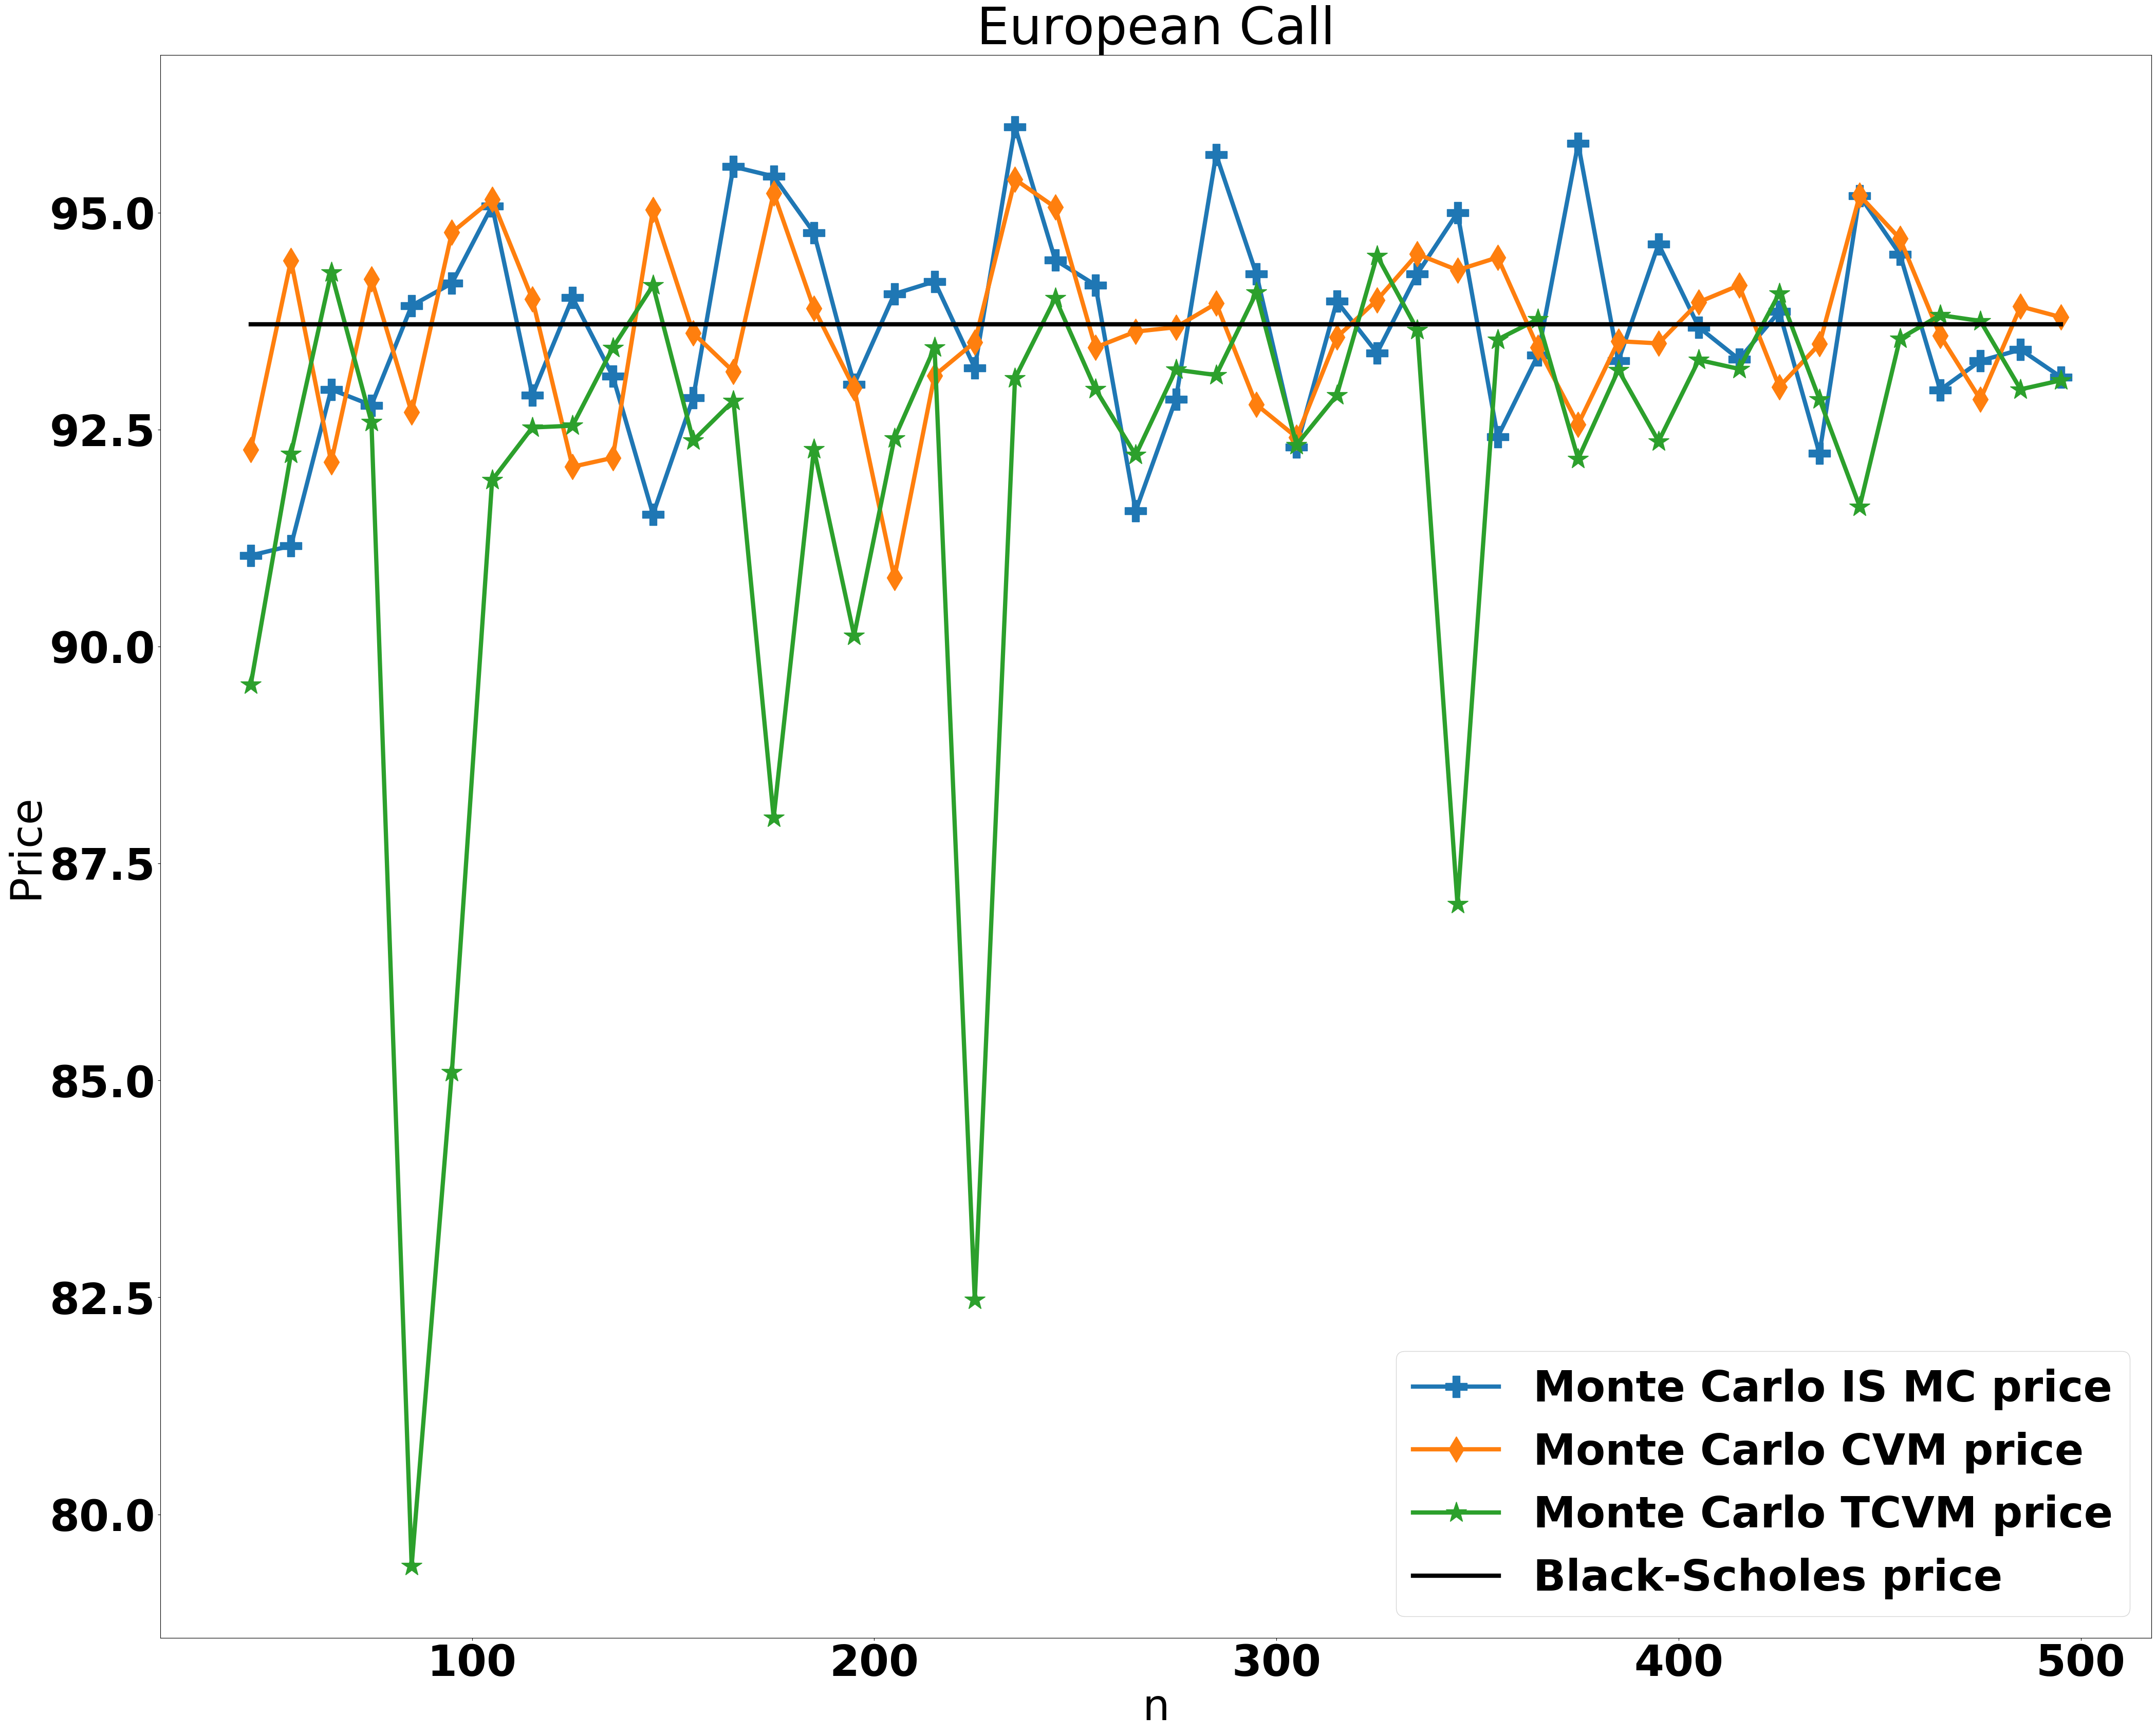

In [1111]:
font = {
        'weight' : 'bold',
        'size'   : 60}

matplotlib.rc('font', **font)
bs = Black_Scholes(T, S, r, sigma, K) #Black-Scholes price
a = len(est6s)
bs = [bs]*a
fig = plt.figure(figsize = [50,40])
ax = plt.subplot(111)

plt.plot(nss[4:50], est6s[4:50],linewidth=6, markersize = 30, marker = "P", label = "Monte Carlo IS MC price")
plt.plot(nss[4:50], est2s[4:50],linewidth=6, markersize = 25, marker = "d", label = "Monte Carlo CVM price")
plt.plot(nss[4:50], est3s[4:50],linewidth=6, markersize = 30, marker = "*", label = "Monte Carlo TCVM price")

plt.plot(nss[4:50], bs[4:50], linewidth=6,  markersize = 199, label = "Black-Scholes price", color = "black")
plt.title('European Call')
plt.xlabel("n")
plt.ylabel("Price")
ax.legend()
plt.show()

We see that important sampling and control variates methods have definitely dominated the competition.

## Variance bar plot

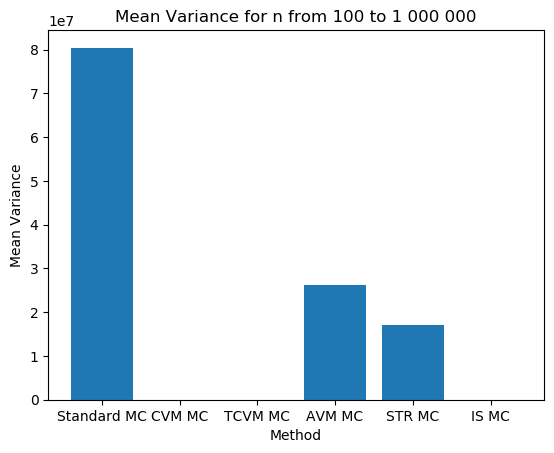

In [923]:
import matplotlib as mpl
mpl.style.use('default')
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.subplot(111)
methods = ["Standard MC", "CVM MC", "TCVM MC", "AVM MC", "STR MC", "IS MC"]
variances = [np.mean(var),np.mean(var2),np.mean(var3),np.mean(var4),np.mean(var5), np.mean(var6)]
ax.bar(methods,variances)
plt.title('Mean Variance for n from 100 to 1 000 000')
plt.xlabel("Method")
plt.ylabel("Mean Variance")
plt.show()

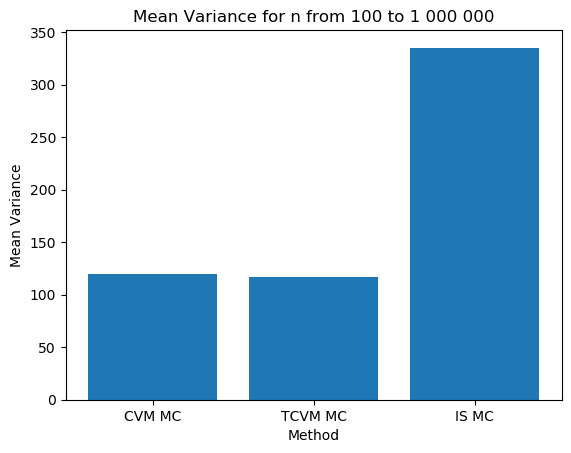

In [924]:
import matplotlib as mpl
mpl.style.use('default')
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.subplot(111)
methods = [ "CVM MC", "TCVM MC", "IS MC"]
variances = [np.mean(var2),np.mean(var3),np.mean(var6)]
ax.bar(methods,variances)
plt.title('Mean Variance for n from 100 to 1 000 000')
plt.xlabel("Method")
plt.ylabel("Mean Variance")
plt.show()

As we can see for these specific market parameters and the Ns, the lowest variance was obtained by control variates methods, and importance sampling was also quite good.

# 3.

## Standard Monte Carlo

In [1112]:
#Market parameters
S = 100
sigma = 1
T = 10
r = 0.1
K = 110

In [1113]:
def asian_ST_and_Y(S = S, T = T, sigma = sigma, r = r, N=10):
    delta_T = T/N
    St_is = np.array([.0]*(N))
    Wt = np.array([.0]*(N+1))
    l = N 
    Z = np.random.normal(size = l)
    t = range(l+1)
    for i in range(l):
        Wt[i+1] = (Wt[i] + math.sqrt(t[i+1] - t[i])*Z[i])
    for i in range(N):
        St_is[i] = S*math.exp((sigma*Wt[i+1]) + (r-(sigma**2)/2)*(i+1)*delta_T)
        
    arithmetic_average = np.mean(St_is)
    geometric_average = scipy.stats.mstats.gmean(St_is)
    return (arithmetic_average,geometric_average)

In [1114]:
def MC_n2(n, S=S, T = T, sigma = sigma, r = r, K = K):
    samples = np.array([0]*n)
    for i in range(n):
        samples[i] = max(asian_ST_and_Y()[0] - K, 0)*math.exp(-r*T)
    mean = np.mean(samples)
    return (samples, mean)

In [1141]:
result = MC_n2(100000)
print("Estimated price: " + np.array2string(result[1]))
print("Estimated variance: " + np.array2string(Var_est(result[0], result[1])))

Estimated price: 46.67631
Estimated variance: 305782.12901607


In [1186]:
#Calculation mean for different n's
est_1 = []
var_1 = []
ns = np.arange(10,1000, 10)
for i in ns:
    est_i = MC_n2(i)
    est_1.append(est_i[1])
    var_1.append(Var_est(est_i[0], est_i[1]))
print("Mean variance: " + np.array2string(np.mean(var_1)))

Mean variance: 443418.57215987


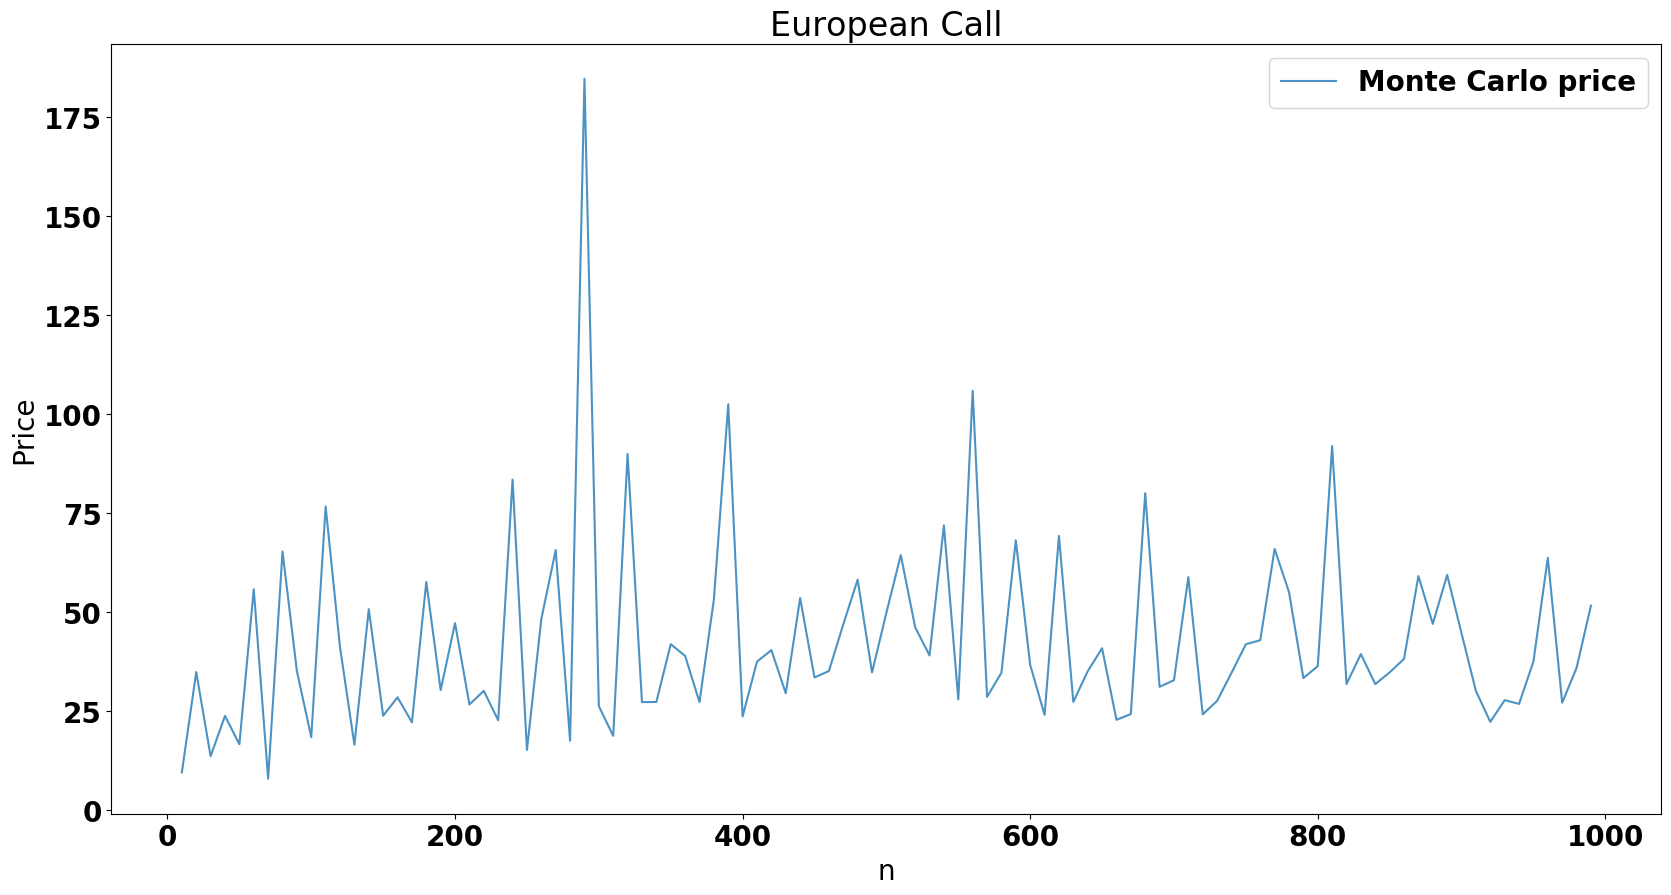

In [1143]:
font = {
        'weight' : 'bold',
        'size'   : 20}

matplotlib.rc('font', **font)
a = len(est_1)
fig = plt.figure(figsize = [20,10])
ax = plt.subplot(111)
plt.plot(ns, est_1, alpha = 0.8, markersize = 4, label = "Monte Carlo price")

plt.title('European Call')
plt.xlabel("n")
plt.ylabel("Price")
ax.legend()
plt.show()

## Control variates method

In [1174]:
def expected_value(S = S, T = T, N = 10, sigma = sigma, r = r, K = K):
    a_s = np.array([0]*(N))
    b_s = np.array([0]*(N))
    delta_T = T/N
    for i in range(N):
        a_s[i] = (i+1)*(delta_T)
        b_s[i] = (i+1)*(delta_T)
    alpha_sq = np.sum(np.square(sigma/N)*np.square(a_s))  
    beta = np.sum(((r-(sigma**2)/2)/(N))*b_s) + np.log(S)
    x = math.exp(beta + alpha_sq/2)*norm.cdf((beta-math.log(K)+alpha_sq)/abs(math.sqrt(alpha_sq)))
    y = K*norm.cdf((beta - math.log(K))/abs(math.sqrt(alpha_sq)))
    e_v = x - y
    return e_v

In [1175]:
def MC_n2_MVC(n, S = S, T = T, sigma = sigma, r = r, K = K):
    samples = np.array([.0]*n)
    for i in range(n):
        asian, Y = asian_ST_and_Y(N=10)
        samples[i] = math.exp(-r*T)*(max(asian - K, 0) - max(Y - K, 0) + expected_value())
        
    mean = np.mean(samples) 
    return (samples, mean)

In [1176]:
result2 = MC_n2_MVC(10000)

In [1177]:
print("Estimated price: " + np.array2string(result2[1]))
print("Estimated variance: " + np.array2string(Var_est(result2[0], result2[1])))

Estimated price: 42.72383882
Estimated variance: 267344.50832342


In [1180]:
#Calculation mean for different n's
est_2 = []
var_2 = []
ns = np.arange(10,1000, 10)
for i in ns:
    est_i = MC_n2_MVC(i)
    est_2.append(est_i[1])
    var_2.append(Var_est(est_i[0], est_i[1]))
print("Mean variance: " + np.array2string(np.mean(var_2)))

Mean variance: 300753.56961731


The average variance was reduced by approximately 1/3, although the results were highly random.

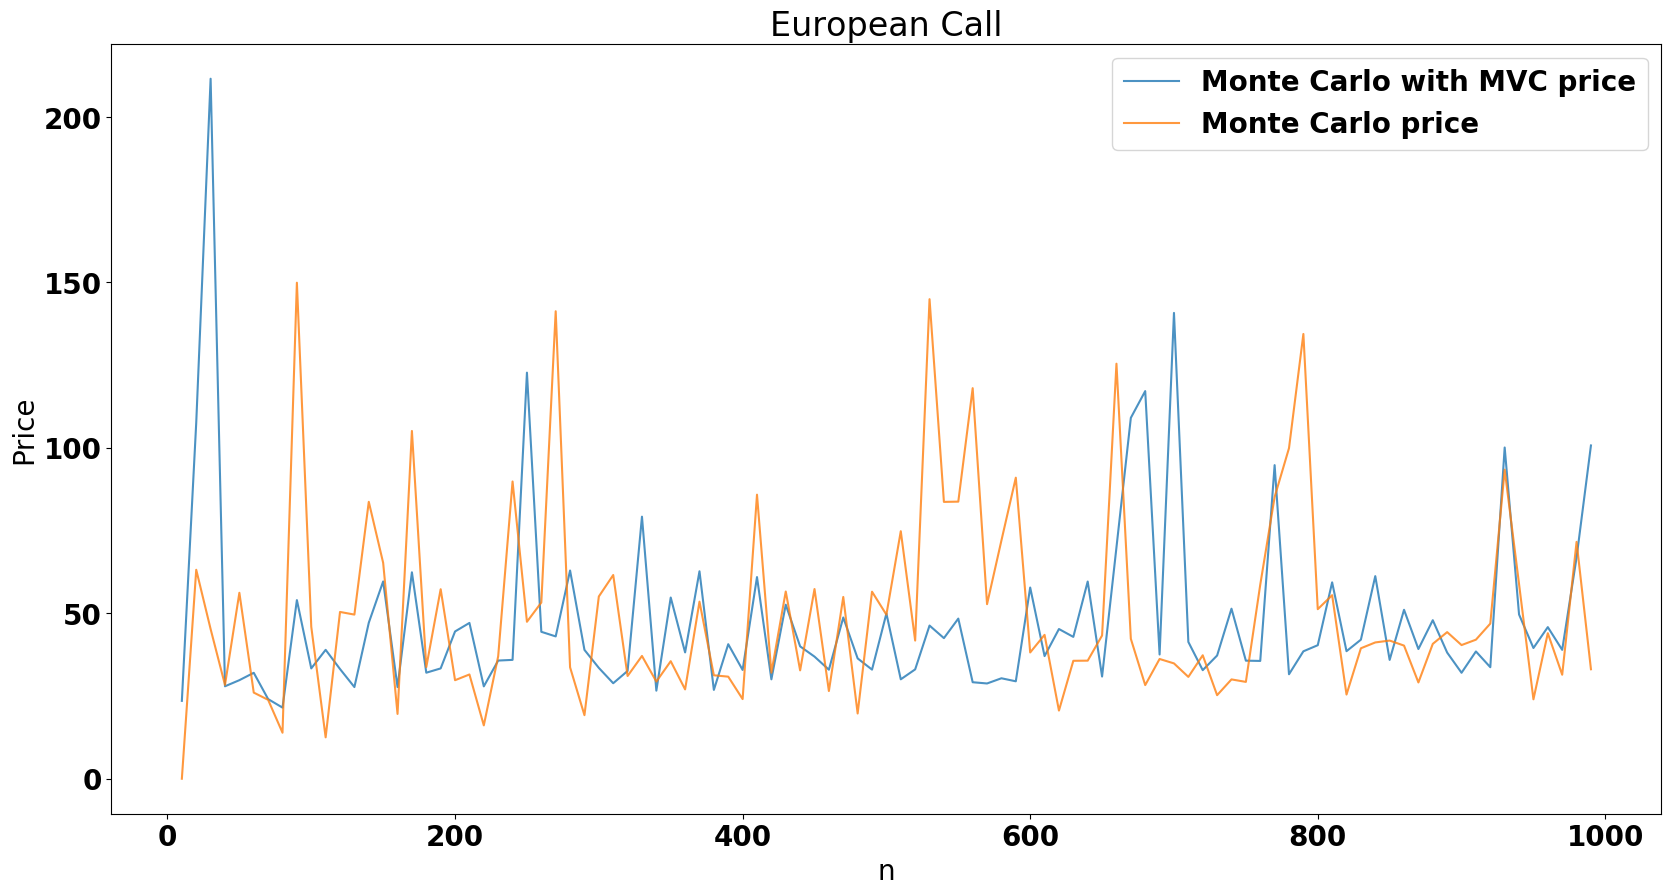

In [1187]:
a = len(est_1)
fig = plt.figure(figsize = [20,10])
ax = plt.subplot(111)
plt.plot(ns, est_2, alpha = 0.8, markersize = 4, label = "Monte Carlo with MVC price")
plt.plot(ns, est_1, alpha = 0.8, markersize = 4, label = "Monte Carlo price")

plt.title('European Call')
plt.xlabel("n")
plt.ylabel("Price")
ax.legend()
plt.show()

As you can see in the chart, there is no significant difference in variance.

# 4.

In [1188]:
np.random.seed(123)

In [61]:
S = 100
sigma = 1
r = 0.1
K1 = 115
K2 = 125
T = 10

# Standard Monte Carlo

In [1194]:
def asian_ST(S = S, T = T, sigma = sigma, r = r, N=10):
    delta_T = T/N
    St_is = np.array([.0]*(N))
    Wt = np.array([.0]*(N+1))
    l = N 
    Z = np.random.normal(size = l)
    t = range(l+1)
    for i in range(l):
        Wt[i+1] = (Wt[i] + math.sqrt(t[i+1] - t[i])*Z[i])
    for i in range(N):
        St_is[i] = S*math.exp((sigma*Wt[i+1]) + (r-(sigma**2)/2)*(i+1)*delta_T)
    return St_is

In [1195]:
def MC_standard(n, S = S, T = T, sigma = sigma, r = r, K1 = K1, K2 = K2):
    samples = np.array([.0]*n)
    for i in range(n):
        asian = asian_ST()
        if(np.sum(asian>K2)>=5):
            value = max(asian[-1] - K1, 0)
        else:
            value = 0
        samples[i] = math.exp(-r*T)*value
        
    mean = np.mean(samples) 
    return (samples, mean)

In [1288]:
np.random.seed(123)
outcome = MC_standard(500000)
print("Estimated price: " + np.array2string(outcome[1]))
print("Estimated variance: " + np.array2string(Var_est(outcome[0], outcome[1])))

Estimated price: 89.96763902
Estimated variance: 21157498.83427459


# Importance sampling 

We will try to use the importance of sampling because it has recently given very good results.

In [42]:
def asian_ST_Y(mi, S = S, T = T, sigma = sigma, r = r, N=10):
    delta_T = T/N
    St_is = np.array([.0]*(N))
    Wt = np.array([.0]*(N+1))
    l = N 
    Z = np.random.normal(size = l)
    t = range(l+1)
    for i in range(l):
        Wt[i+1] = (Wt[i] + math.sqrt(t[i+1] - t[i])*Z[i])
    Wt = Wt + mi
    for i in range(N):
        St_is[i] = S*math.exp((sigma*Wt[i+1]) + (r-(sigma**2)/2)*(i+1)*delta_T)
    return (St_is, Wt)

In [43]:
def MC_IS(n, S=S, T = T, sigma = sigma, r = r, K1 = K1, K2 = K2, mi = 0, N = 10):
    samples = np.array([.0]*n)
    for i in range(n):
        asian, Y = asian_ST_Y(mi)
        Y = Y[1:]
        if(np.sum(asian>K2)>=5):
            value = max(asian[-1] - K1, 0)
        else:
            value = 0
        
        cov = [[0] * N for i in range(N)]
        for g in range(N):
            for j in range(N):
                cov[g][j] = min(g+1, j+1)
        
        meanY = [mi]*N
        meanWt = [.0]*N
        f_Wt = scipy.stats.multivariate_normal.pdf(Y, mean = meanWt, cov = cov)
        f_Y = scipy.stats.multivariate_normal.pdf(Y, mean = meanY, cov = cov)
       
        samples[i] = value * math.exp(-r*T) * (f_Wt/f_Y)
    mean = np.mean(samples)
    return (samples, mean)

In [46]:
np.random.seed(123)
outcomeIC = MC_IS(500000, mi = 1)
print("Estimated price: " + np.array2string(outcomeIC[1]))
print("Estimated variance: " + np.array2string(Var_est(outcomeIC[0], outcomeIC[1])))

Estimated price: 84.81335989
Estimated variance: 6625581.16242661


The result is 10 times better, but that's not what we're looking for. Let's check the results for different ns.

In [48]:
mi_s = [-0.1, -0.01, 0, 0.001,0.01, 0.1, 0.5, 1]
for mi in mi_s:
    np.random.seed(123)
    oc= MC_IS(50000, mi = mi)
    print("Estimated variance for mi =  "+ str(mi) + ": " + np.array2string(Var_est(oc[0], oc[1])))
    print(oc[1])

Estimated variance for mi =  -0.1: 4276888.68918761
71.12180619785305
Estimated variance for mi =  -0.01: 4147379.99236291
72.46957692500378
Estimated variance for mi =  0: 4132529.4413542
72.59821363095271
Estimated variance for mi =  0.001: 4131040.10483811
72.61150197138151
Estimated variance for mi =  0.01: 4117616.86555229
72.70647861154679
Estimated variance for mi =  0.1: 3982979.16793217
73.75736733669648
Estimated variance for mi =  0.5: 3488267.88756533
77.6717167636134
Estimated variance for mi =  1: 3194734.14704328
79.59110737416648


In [50]:
mi_s = [1,2,3,4]
for mi in mi_s:
    np.random.seed(123)
    oc= MC_IS(50000, mi = mi)
    print("Estimated variance for mi =  "+ str(mi) + ": " + np.array2string(Var_est(oc[0], oc[1])))
    print(oc[1])

Estimated variance for mi =  1: 3194734.14704328
79.59110737416648
Estimated variance for mi =  2: 4209280.41125515
81.90839954095172
Estimated variance for mi =  3: 16499179.80853339
87.47422402660978
Estimated variance for mi =  4: 51045751.31482912
88.79349962087304


The best result was obtained for mi = 1, although it is not impressive, so let's look for something better.

# Antithetical variates

Let's try something simpler. 
We will again use the symmetry of the normal distribution.

In [52]:
def asian_ST_Y2(S = S, T = T, sigma = sigma, r = r, N=10):
    delta_T = T/N
    St_is = np.array([.0]*(N))
    St_is2 = np.array([.0]*(N))
    Wt = np.array([.0]*(N+1))
    Wt2 = np.array([.0]*(N+1))
    l = N 
    Z = np.random.normal(size = l)
    t = range(l+1)
    for i in range(l):
        Wt[i+1] = (Wt[i] + math.sqrt(t[i+1] - t[i])*Z[i])
        Wt2[i+1] = (Wt2[i] + math.sqrt(t[i+1] - t[i])*-Z[i])
    for i in range(N):
        St_is[i] = S*math.exp((sigma*Wt[i+1]) + (r-(sigma**2)/2)*(i+1)*delta_T)
        St_is2[i] = S*math.exp((sigma*Wt2[i+1]) + (r-(sigma**2)/2)*(i+1)*delta_T)
    return (St_is, St_is2)

In [54]:
def MC_AV(n, S = S, T = T, sigma = sigma, r = r, K1 = K1, K2 = K2):
    samples = np.array([.0]*n)
    for i in range(n):
        asian, asian2 = asian_ST_Y2()
        if(np.sum(asian>K2)>=5):
            value = max(asian[-1] - K1, 0)
        else:
            value = 0
        if(np.sum(asian2>K2)>=5):
            value2 = max(asian2[-1] - K1, 0)
        else:
            value2 = 0
        samples[i] = math.exp(-r*T)*(value + value2)/2 
        
    mean = np.mean(samples) 
    return (samples, mean)

In [55]:
np.random.seed(123)
outcome = MC_AV(500000)
print("Estimated price: " + np.array2string(outcome[1]))
print("Estimated variance: " + np.array2string(Var_est(outcome[0], outcome[1])))

Estimated price: 91.20658771
Estimated variance: 9073942.60799843


This is twice better result, let's try to improve it.

# Antithetical variates v2

Now we will use not only the symmetry of the normal distribution, but also the fact that our variable is multidimensional.

In [1298]:
def asian_ST_Y3(S = S, T = T, sigma = sigma, r = r, N=10):
    delta_T = T/N
    St_is = np.array([.0]*(N))
    St_is2 = np.array([.0]*(N))
    St_is3 = np.array([.0]*(N))
    St_is4 = np.array([.0]*(N))
    Wt = np.array([.0]*(N+1))
    Wt2 = np.array([.0]*(N+1))
    Wt3 = np.array([.0]*(N+1))
    Wt4 = np.array([.0]*(N+1))
    l = N 
    Z = np.random.normal(size = l)
    t = range(l+1)
    for i in range(l):
        Wt[i+1] = (Wt[i] + math.sqrt(t[i+1] - t[i])*Z[i])
        Wt2[i+1] = (Wt2[i] + math.sqrt(t[i+1] - t[i])*-Z[i])
        Wt3[i+1] = (Wt3[i] + math.sqrt(t[i+1] - t[i])*((-1)**i)*Z[i])
        Wt4[i+1] = (Wt4[i] + math.sqrt(t[i+1] - t[i])*((-1)**(i+1))*Z[i])
    for i in range(N):
        St_is[i] = S*math.exp((sigma*Wt[i+1]) + (r-(sigma**2)/2)*(i+1)*delta_T)
        St_is2[i] = S*math.exp((sigma*Wt2[i+1]) + (r-(sigma**2)/2)*(i+1)*delta_T)
        St_is3[i] = S*math.exp((sigma*Wt3[i+1]) + (r-(sigma**2)/2)*(i+1)*delta_T)
        St_is4[i] = S*math.exp((sigma*Wt4[i+1]) + (r-(sigma**2)/2)*(i+1)*delta_T)
    return (St_is, St_is2, St_is3, St_is4)

In [1297]:
def MC_AVv2(n, S = S, T = T, sigma = sigma, r = r, K1 = K1, K2 = K2):
    samples = np.array([.0]*n)
    for i in range(n):
        asian, asian2, asian3, asian4 = asian_ST_Y3()
        if(np.sum(asian>K2)>=5):
            value = max(asian[-1] - K1, 0)
        else:
            value = 0
        if(np.sum(asian2>K2)>=5):
            value2 = max(asian2[-1] - K1, 0)
        else:
            value2 = 0
        if(np.sum(asian3>K2)>=5):
            value2 = max(asian3[-1] - K1, 0)
        else:
            value3 = 0
        if(np.sum(asian4>K2)>=5):
            value4 = max(asian4[-1] - K1, 0)
        else:
            value4 = 0
        samples[i] = math.exp(-r*T)*(value + value2 + value3 + value4)/4
        
    mean = np.mean(samples) 
    return (samples, mean)

In [1299]:
np.random.seed(123)
outcome = MC_AVv2(500000)
print("Estimated price: " + np.array2string(outcome[1]))
print("Estimated variance: " + np.array2string(Var_est(outcome[0], outcome[1])))

Estimated price: 87.9606106
Estimated variance: 5060004.25918149


Once again we received a better result, twice better than previous one. We will try to use a similar scheme and, in addition to permutation of the sign of variable from normal distribution, add permutations of the order in the vector of variables of normal distribution.

# Antithetical variates v3 

It would take too long if we would like to compare all permutations 1 and -1 with a length of 10, so we will use 10 different ones.

In [1321]:
def asian_ST_Final(S = S, T = T, sigma = sigma, r = r, N=10):
    delta_T = T/N
    St_is = np.array([.0]*(N))
    St_iss = []
    Wt = np.array([.0]*(N+1))
    Wts = []
    l = N 
    Z = np.random.normal(size = l)
    t = range(l+1)
    series = np.array(list(itertools.product([1, -1], repeat = 10))) # Series of 1 and -1
    delta = series.shape[0]/10
    new = []
    for i in range(10):
        new.append(series[int(i*delta)])
        
    for ser in new:
        Wt = np.array([.0]*(N+1))
        for i in range(l):
            Wt[i+1] = (Wt[i] + math.sqrt(t[i+1] - t[i])*ser[i]*Z[i])
        Wts.append(Wt)
    for Wti in Wts:
        for i in range(N):
            St_is[i] = S*math.exp((sigma*Wti[i+1]) + (r-(sigma**2)/2)*(i+1)*delta_T)
        St_iss.append(St_is)
    return St_iss

In [1322]:
def MC_AVv3(n, S = S, T = T, sigma = sigma, r = r, K1 = K1, K2 = K2):
    samples = np.array([.0]*n)
    for i in range(n):
        asians = asian_ST_Final()
        values = np.array([.0]*len(asians))
        for j, asian in enumerate(asians):
            if(np.sum(asian>K2)>=5):
                values[j] = max(asian[-1] - K1, 0)
    
        samples[i] = math.exp(-r*T)*(np.mean(np.array(values)))
        
    mean = np.mean(samples) 
    return (samples, mean)

In [1323]:
np.random.seed(123)
outcome = MC_AVv3(500000)
print("Estimated price: " + np.array2string(outcome[1]))
print("Estimated variance: " + np.array2string(Var_est(outcome[0], outcome[1])))

Estimated price: 83.56860033
Estimated variance: 17438130.8013338


This time we have received a worse result compared to the previous one. 
So let's try an another technique.

# Stratified Monte Carlo

In [82]:
def asian_STr(k, i, S = S, T = T, sigma = sigma, r = r, N=10):
    delta_T = T/N
    St_is = np.array([.0]*(N))
    Wt = np.array([.0]*(N+1))
    l = N 
    U = np.random.uniform(size = l)
    
    Z = norm._ppf((i - 1 + U)/k)
    t = range(l+1)
    for i in range(l):
        Wt[i+1] = math.sqrt(t[i+1])*Z[i] #(Wt[i] + math.sqrt(t[i+1] - t[i])*Z[i])
    for i in range(N):
        St_is[i] = S*math.exp((sigma*Wt[i+1]) + (r-(sigma**2)/2)*(i+1)*delta_T)
    return St_is

In [83]:
def MC_str(n, S = S, T = T, sigma = sigma, r = r, K1 = K1, K2 = K2, k = 100):
    samples = np.array([.0]*n)
    for i in range(n):
        j = i%k + 1
        asian = asian_STr(k,j)
        if(np.sum(asian>K2)>=5):
            value = max(asian[-1] - K1, 0)
        else:
            value = 0
        samples[i] = math.exp(-r*T)*value
        
    mean = np.mean(samples) 
    return (samples, mean)

In [88]:
k_s = [10, 50, 100,1000, 5000, 10000, 20000, 30000, 50000]
for k in k_s:
    np.random.seed(123)
    oc= MC_str(500000, k = k)
    print("Estimated variance for k =  "+ str(k) + ": " + np.array2string(Var_est(oc[0], oc[1])))
    print("Price: " + np.array2string(oc[1]))

Estimated variance for k =  10: 43372925.35195323
Price: 95.05059417
Estimated variance for k =  50: 9014582.58643916
Price: 83.8445119
Estimated variance for k =  100: 16647146.34233358
Price: 90.3442094
Estimated variance for k =  1000: 26514520.11490332
Price: 94.89452487
Estimated variance for k =  5000: 41981050.90760975
Price: 92.73994896
Estimated variance for k =  10000: 8978778.25755649
Price: 86.23231259
Estimated variance for k =  20000: 16786237.49073657
Price: 91.20052776
Estimated variance for k =  30000: 11799695.18247623
Price: 84.575462
Estimated variance for k =  50000: 20640069.6354932
Price: 91.59457892


The results are better than with a standard monte carlo, but they are still unsatisfactory. So let's try an another technique that has previously given us very good results.

# Control variates method 

We will use e ^ (- rT) * ST as the control variable

In [15]:
def asian_STCV(S = S, T = T, sigma = sigma, r = r, N=10):
    delta_T = T/N
    St_is = np.array([.0]*(N))
    Wt = np.array([.0]*(N+1))
    l = N 
    Z = np.random.normal(size = l)
    t = range(l+1)
    for i in range(l):
        Wt[i+1] = (Wt[i] + math.sqrt(t[i+1] - t[i])*Z[i])
    for i in range(N):
        St_is[i] = S*math.exp((sigma*Wt[i+1]) + (r-(sigma**2)/2)*(i+1)*delta_T)
    return St_is

In [17]:
def MC_CV(n, S = S, T = T, sigma = sigma, r = r, K1 = K1, K2 = K2):
    samples = np.array([.0]*n)
    for i in range(n):
        asian = asian_STCV()
        if(np.sum(asian>K2)>=5):
            value = max(asian[-1] - K1, 0)
        else:
            value = 0
        mi = S
        samples[i] = math.exp(-r*T)*(value - asian[-1]) + mi
        
    mean = np.mean(samples) 
    return (samples, mean)

In [34]:
np.random.seed(123)
outcome = MC_CV(500000)
print("Estimated price: " + np.array2string(outcome[1]))
print("Estimated variance: " + np.array2string(Var_est(outcome[0], outcome[1])))

Estimated price: 90.03000694
Estimated variance: 3605.37059972


We obtained a very good result and reduced the variance by 10^4 times.

# Control/Antithetical variates method mix

In [57]:
def MC_CA(n, S = S, T = T, sigma = sigma, r = r, K1 = K1, K2 = K2):
    samples = np.array([.0]*n)
    for i in range(n):
        asian, asian2 = asian_ST_Y2()
        if(np.sum(asian>K2)>=5):
            value = max(asian[-1] - K1, 0)
        else:
            value = 0
        if(np.sum(asian2>K2)>=5):
            value2 = max(asian2[-1] - K1, 0)
        else:
            value2 = 0
        control = (asian[-1] + asian2[-1])/2
        samples[i] = math.exp(-r*T)*((value + value2)/2 - control) + S
        
    mean = np.mean(samples) 
    return (samples, mean)

In [58]:
np.random.seed(123)
outcome = MC_CA(500000)
print("Estimated price: " + np.array2string(outcome[1]))
print("Estimated variance: " + np.array2string(Var_est(outcome[0], outcome[1])))

Estimated price: 90.05295687
Estimated variance: 2495.21347384


Thanks to the mix we have obtained an even better result, obtaining an improvement of 1/3! 
Since this method gives such good results, let's try to apply to it an improved version of control variables and the aforementioned version of the improved antithetical variables.

# Tuning

## Normal Turbo Control Variates

In [62]:
def MC_TCVM(n, S = S, T = T, sigma = sigma, r = r, K1 = K1, K2 = K2):
    samples = np.array([.0]*n)
    X_is = np.array([.0]*n)
    Y_is = np.array([.0]*n)
    for i in range(n):
        asian = asian_STCV()
        Y_is[i] = asian[-1]
        if(np.sum(asian>K2)>=5):
            value = max(asian[-1] - K1, 0)
        else:
            value = 0
        X_is[i] = math.exp(-r*T)*value
    b_hat = np.sum((X_is - np.mean(X_is))*(Y_is-np.mean(Y_is))) / (np.sum(np.square(Y_is-np.mean(Y_is))))
    u_k = b_hat*S*math.exp(r*T)                                                              
    for i in range(n):
        samples[i] = X_is[i] - b_hat*Y_is[i] + u_k
    mean = np.mean(samples) 
    return (samples, mean)

In [63]:
np.random.seed(123)
outcome = MC_TCVM(500000)
print("Estimated price: " + np.array2string(outcome[1]))
print("Estimated variance: " + np.array2string(Var_est(outcome[0], outcome[1])))

Estimated price: 90.02998775
Estimated variance: 3603.36559454


This gave a slightly better result than the usual method of control variables.

# Mega-Turbo-Extreme-Control/Antithetical-variates-method-mix ®

Unfortunately, in combination with the modified method of antithetical variables, we received worse results than with usual one, which is why we used the latter.

In [67]:
def MC_MTECAVM(n, S = S, T = T, sigma = sigma, r = r, K1 = K1, K2 = K2):
    samples = np.array([.0]*n)
    X_is = np.array([.0]*n)
    Y_is = np.array([.0]*n)
    X_is2 = np.array([.0]*n)
    Y_is2 = np.array([.0]*n)
    for i in range(n):
        asian, asian2 = asian_ST_Y2()
        Y_is[i] = asian[-1]
        Y_is2[i] = asian2[-1]
        if(np.sum(asian>K2)>=5):
            value = max(asian[-1] - K1, 0)
        else:
            value = 0
        X_is[i] = math.exp(-r*T)*value
        
        if(np.sum(asian2>K2)>=5):
            value2 = max(asian2[-1] - K1, 0)
        else:
            value2 = 0
        X_is2[i] = math.exp(-r*T)*value2
    b_hat = np.sum((X_is - np.mean(X_is))*(Y_is-np.mean(Y_is))) / (np.sum(np.square(Y_is-np.mean(Y_is))))
    u_k = b_hat*S*math.exp(r*T)
    b_hat2 = np.sum((X_is2 - np.mean(X_is2))*(Y_is2-np.mean(Y_is2))) / (np.sum(np.square(Y_is2-np.mean(Y_is2))))
    u_k2 = b_hat2*S*math.exp(r*T)   
    for i in range(n):
        samples[i] = (X_is[i] + X_is2[i])/2 - (b_hat*Y_is[i] + b_hat2*Y_is2[i])/2 + (u_k + u_k2)/2
    mean = np.mean(samples) 
    return (samples, mean)

In [68]:
np.random.seed(123)
outcome = MC_MTECAVM(500000)
print("Estimated price: " + np.array2string(outcome[1]))
print("Estimated variance: " + np.array2string(Var_est(outcome[0], outcome[1])))

Estimated price: 90.05369453
Estimated variance: 2493.67716338


This is the best result we have achieved so far, it is quite impressive, because we managed to reduce the variance by about 10 ^ 4 times compared to the standard Monte Carlo.

,,Potwierdzam samodzielność powyższej pracy oraz niekorzystanie przeze mnie z niedozwolonych źródeł"